# Laboratory 1 — Feed Forward Neural Networks (FFNN)

This notebook implements the first lab of the *AI and Cybersecurity* course.  

It follows the official brief (`resources/Lab1_FFNN.txt`) and develops a full **Machine Learning pipeline** using PyTorch to explore, train, and evaluate Feed Forward Neural Networks on the CICIDS2017 dataset.

This lab is organized into tasks:
- Task 1: Data preprocessing (cleaning, splitting, outliers, normalization)
- Task 2: Shallow NN (1 layer), train sizes {32, 64, 128}, metrics and analysis; then ReLU change
- Task 3: Impact of specific features (Destination Port), bias test and port removal
- Task 4: Loss function impact (weighted CrossEntropy)
- Task 5: Deep NN, batch size, optimizer comparisons
- Task 6: Overfitting and regularization (dropout, batchnorm, weight decay)

## Setup

In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/eliainnocenti/Documents/Projects/LaTeX/AImSecure/venv/bin/python3.14
3.14.0 (main, Oct  7 2025, 09:34:52) [Clang 17.0.0 (clang-1700.3.19.1)]


In [2]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Device Settings

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"The device is set to: {device}")

The device is set to: cpu


### Paths setup


In [4]:
# --- Define Paths ---
project_path = '../'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: ../
Data path: ../data/
Results path: ../results/


In [5]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {save_path}")

## Task 1 — Data preprocessing

In this task, we prepare the dataset and ensure proper data quality and normalization before training.  
We will:
- Load the dataset from `lab/data/dataset_lab_1.csv`.
- Inspect basic statistics, feature ranges, and class distribution.
- Remove missing values and duplicates (report before/after counts).
- Split the data into **train / validation / test (60% / 20% / 20%)**, using a fixed random seed for reproducibility.
- Perform **outlier analysis** (e.g., KDE, Z-score, IQR) and decide on an appropriate **scaling method**.
- Fit the scaler on the training data only and apply it to validation and test splits.

In [6]:
# --- Load dataset and perform initial inspection ---

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

# Load Dataset
file_path = data_path + 'dataset_lab_1.csv'
df = pd.read_csv(file_path)

# Basic info
print("Shape (raw):", df.shape)
print("Columns:", list(df.columns))

print("\nLabel distribution (raw):")
print(df['Label'].value_counts(dropna=False))

Shape (raw): (31507, 17)
Columns: ['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port', 'Label']

Label distribution (raw):
Label
Benign         20000
DoS Hulk        5000
PortScan        5000
Brute Force     1507
Name: count, dtype: int64


In [7]:
df

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.4,1448,12743.263,0,0,19.833334,98776.15,322.16666,119,6,36.258636,6,443,Benign
1,117,1.170000e+02,0,0.0,0,0.000,1,0,0.000000,0.00,0.00000,0,1,17094.018000,1,52631,Benign
2,142,1.420000e+02,0,0.0,0,84507.040,0,0,6.000000,0.00,6.00000,6,2,14084.507000,2,80,Benign
3,191,6.366667e+01,0,52.0,52,921465.940,1,0,36.000000,0.00,42.40000,36,2,20942.408000,2,53,Benign
4,4,4.000000e+00,0,0.0,0,3000000.000,0,0,6.000000,0.00,6.00000,6,2,500000.000000,2,49467,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31502,5710955,1.903652e+06,0,0.0,0,0.000,0,0,0.000000,4037277.80,0.00000,0,3,0.700408,3,80,Brute Force
31503,5862561,1.954187e+06,0,0.0,0,0.000,0,0,0.000000,4144374.80,0.00000,0,3,0.682296,3,80,Brute Force
31504,5854872,1.951624e+06,0,0.0,0,0.000,0,0,0.000000,4139029.80,0.00000,0,3,0.683192,3,80,Brute Force
31505,5555547,1.851849e+06,0,0.0,0,0.000,0,0,0.000000,3927356.50,0.00000,0,3,0.720001,3,80,Brute Force


In [8]:
def plot_class_distribution(
    df,
    name_fig='class_distribution',
    label_col='Label',
    save_path='./plots/',
    fig_size=(8, 5),
    palette='pastel'
):
    """
    Plot the number of samples for each class.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_col (str): The name of the label column. Defaults to 'Label'.
        save_path (str): The directory to save the plot. Defaults to './plots/'.
        fig_size (tuple): Size of the figure. Defaults to (8, 5).
        palette (str): Seaborn palette.
    """
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # Create a countplot showing the distribution of classes
    sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, ax=ax, palette=palette, hue=label_col, legend=False)

    # Set the title and labels for the plot
    ax.set_title("Class Distribution")
    ax.set_xlabel("Traffic Type")
    ax.set_ylabel("Count")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    # Save the plot to the specified path
    save_plot(fig, name_fig, save_path)

Saved plot: ../results/images/task1_plots/class_distribution.png


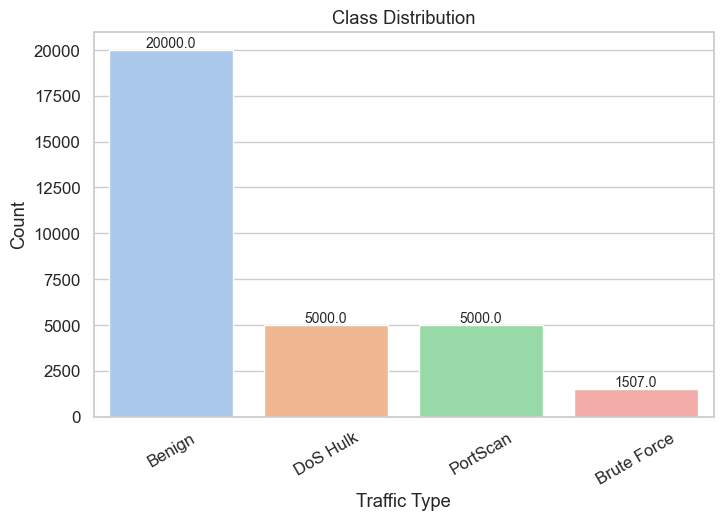

In [9]:
# --- Visualize raw data characteristics and distributions ---

# Plot class distribution to understand data balance
plot_class_distribution(df, 'class_distribution', save_path=save_dir)

### Removing NaN and duplicates

In [10]:
# --- Remove NaN and duplicates ---

raw_n = len(df)

# Drop NaN
df = df.dropna()
clean_n = len(df)
print(f"Removed {raw_n-clean_n} rows (NaN)")

# Drop duplicates
df = df.drop_duplicates()
clean_n = len(df)
print(f"Removed {raw_n-clean_n} rows (duplicates)")

print(f"New shape: {df.shape}")

Removed 20 rows (NaN)
Removed 2114 rows (duplicates)
New shape: (29393, 17)


In [11]:
# --- Handle infinite values ---

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for and report the number of infinite values (now NaNs)
inf_counts = df.isnull().sum()
print("\nNumber of infinite values (replaced with NaN) per column:")
print(inf_counts[inf_counts > 0])

# Drop rows with NaN values (including those that were originally infinite)
initial_rows = len(df)
df.dropna(inplace=True)
rows_after_inf_nan_drop = len(df)

print(f"\nRemoved {initial_rows - rows_after_inf_nan_drop} rows containing infinite or NaN values. New shape: {df.shape}")


Number of infinite values (replaced with NaN) per column:
Flow Bytes/s      7
Flow Packets/s    7
dtype: int64

Removed 7 rows containing infinite or NaN values. New shape: (29386, 17)


#### Q: How many samples did you have before and after removing missing and duplicates entries?

We initially had **31507 samples** bold text, and after removing missing, duplicate, and infinite entries, we obtained 29,386 clean samples. In total, **2121** (2114 missing and duplicates + 7 infinite values) rows **were removed** during the data cleaning process.

In [12]:
print("\nLabel distribution (after NaN and duplicates removal):")
print(df['Label'].value_counts())


Label distribution (after NaN and duplicates removal):
Label
Benign         19242
PortScan        4849
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64


In [13]:
# Encode labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

df.head(10)

,Flow Duration,Flow IAT Mean,Fwd PSH Flags,Bwd Packet Length Mean,Bwd Packet Length Max,Flow Bytes/s,Down/Up Ratio,SYN Flag Count,Fwd Packet Length Mean,Fwd IAT Std,Packet Length Mean,Fwd Packet Length Max,Subflow Fwd Packets,Flow Packets/s,Total Fwd Packets,Destination Port,Label
0,303376,3.033760e+04,0,749.400000,1448,1.274326e+04,0,0,19.833334,98776.150,322.166660,119,6,36.258636,6,443,0
1,117,1.170000e+02,0,0.000000,0,0.000000e+00,1,0,0.000000,0.000,0.000000,0,1,17094.018000,1,52631,0
2,142,1.420000e+02,0,0.000000,0,8.450704e+04,0,0,6.000000,0.000,6.000000,6,2,14084.507000,2,80,0
3,191,6.366667e+01,0,52.000000,52,9.214659e+05,1,0,36.000000,0.000,42.400000,36,2,20942.408000,2,53,0
4,4,4.000000e+00,0,0.000000,0,3.000000e+06,0,0,6.000000,0.000,6.000000,6,2,500000.000000,2,49467,0
5,162322,3.959073e+03,0,19.416666,51,4.102956e+03,1,0,11.111111,30630.129,15.488372,43,18,258.744960,18,21,0
6,61050653,2.907174e+06,0,22.818182,233,5.230083e+01,1,0,267.454560,5145240.000,138.826080,1460,11,0.360357,11,80,0
7,108,1.080000e+02,0,0.000000,0,1.111111e+05,0,0,6.000000,0.000,6.000000,6,2,18518.518000,2,80,0
8,764920,7.649200e+05,0,0.000000,0,1.568792e+01,0,0,6.000000,0.000,6.000000,6,2,2.614652,2,443,0
9,122255,6.112750e+04,0,0.000000,0,0.000000e+00,0,0,0.000000,0.000,0.000000,0,2,24.538874,2,443,0


In [14]:
# --- Display the label encoding mapping ---
print("\nLabel Encoding Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Encoding Mapping:
Benign: 0
Brute Force: 1
DoS Hulk: 2
PortScan: 3


In [15]:
# Checking again null values
print(df.isnull().sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


In [16]:
# Checking again for the infinite values
print(df.isin([np.inf, -np.inf]).sum())

Flow Duration             0
Flow IAT Mean             0
Fwd PSH Flags             0
Bwd Packet Length Mean    0
Bwd Packet Length Max     0
Flow Bytes/s              0
Down/Up Ratio             0
SYN Flag Count            0
Fwd Packet Length Mean    0
Fwd IAT Std               0
Packet Length Mean        0
Fwd Packet Length Max     0
Subflow Fwd Packets       0
Flow Packets/s            0
Total Fwd Packets         0
Destination Port          0
Label                     0
dtype: int64


### Split data

We use a **stratified approach** due to the class imbalance.

In [17]:
# --- Split data ---

# Split features/target
label_col = 'Label'
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols].values
y = df[label_col].values

# Train/val/test split 60/20/20 with stratify
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print("Data Splits:")
print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples\n")

def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    count_width = 6
    print(f"{name:<8}", end=" ")
    for label, count in zip(labels, counts):
        print(f"{label}: {count:>{count_width},}", end="   ")
    print()

print_label_counts("Train", y_train)
print_label_counts("Val", y_val)
print_label_counts("Test", y_test)

Data Splits:
Train set: 17,631 samples
Validation set: 5,877 samples
Test set: 5,878 samples

Train    0: 11,545   1:    856   2:  2,321   3:  2,909   
Val      0:  3,848   1:    286   2:    773   3:    970   
Test     0:  3,849   1:    285   2:    774   3:    970   


### Outliers Detection

In [18]:
# --- Outlier detection (Z-score and IQR) ---

# Convert X_train to DataFrame to use select_dtypes
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)

# Z-score method
zs = ((X_train_df[num_cols] - X_train_df[num_cols].mean()) / X_train_df[num_cols].std(ddof=0)).abs()
outlier_counts_z = (zs > 3).sum().sort_values(ascending=False)
print("\n[Z-SCORE OUTLIERS] features:")
print(outlier_counts_z)

# IQR method
Q1 = X_train_df[num_cols].quantile(0.25)
Q3 = X_train_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train_df[num_cols] < (Q1 - 1.5 * IQR)) | (X_train_df[num_cols] > (Q3 + 1.5 * IQR))).sum()
outlier_counts_iqr = outliers_iqr.sort_values(ascending=False)
print("\n[IQR OUTLIERS] features:")
print(outlier_counts_iqr)

['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port']

[Z-SCORE OUTLIERS] features:
Fwd PSH Flags             708
SYN Flag Count            708
Fwd IAT Std               567
Bwd Packet Length Max     523
Flow Packets/s            522
Bwd Packet Length Mean    340
Packet Length Mean        272
Destination Port          247
Fwd Packet Length Max     238
Flow IAT Mean             207
Fwd Packet Length Mean    157
Subflow Fwd Packets        88
Total Fwd Packets          88
Down/Up Ratio              48
Flow Bytes/s               37
Flow Duration               0
dtype: int64

[IQR OUTLIERS] features:
Bwd Packet Length Max     3951
Destination Port          3879
Flow Duration             3443
Bwd Packet Length Mean    3180
Pac

Saved plot: ../results/images/task1_plots/raw_distributions.pdf


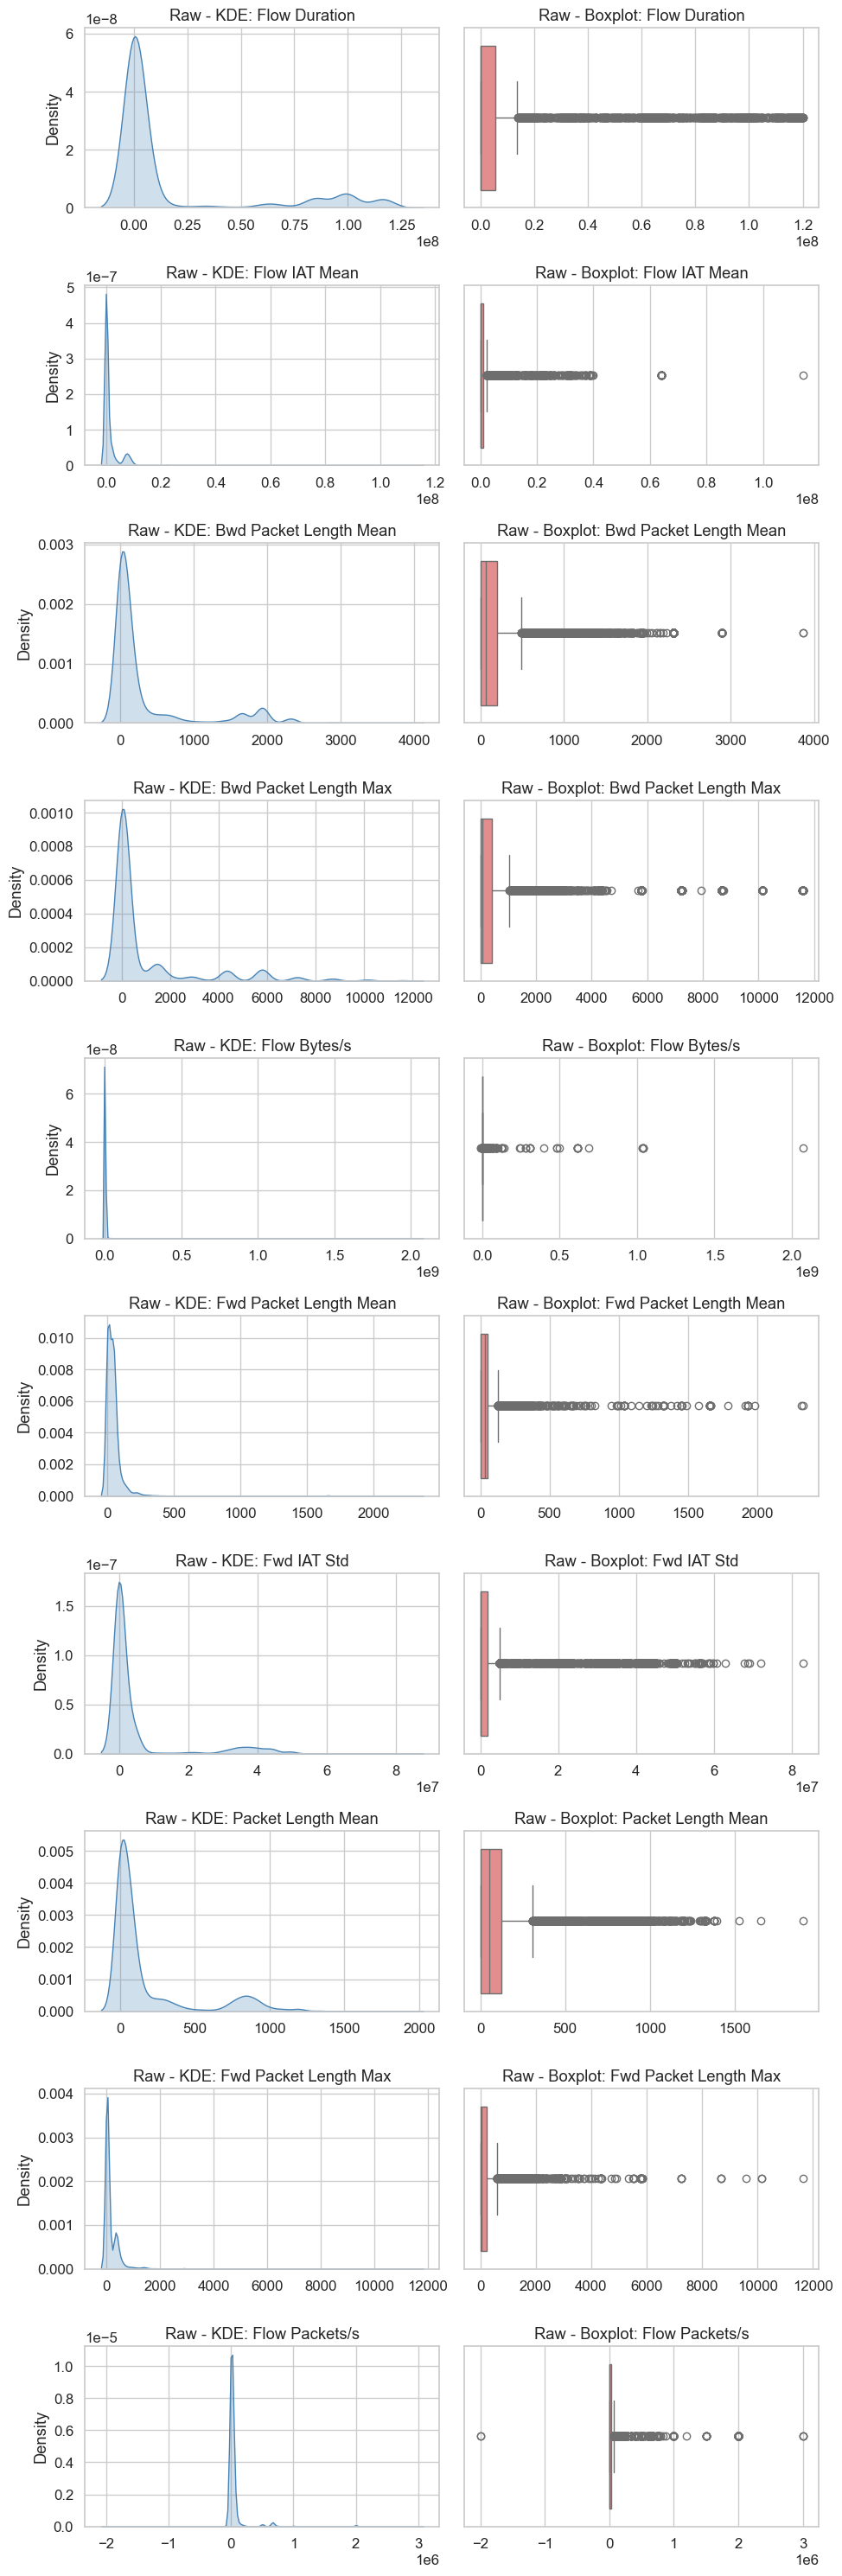

In [19]:
# --— Visualize raw distributions for selected features ---

selected_features = [
    'Flow Duration', 'Flow IAT Mean', 'Bwd Packet Length Mean',
    'Bwd Packet Length Max', 'Flow Bytes/s', 'Fwd Packet Length Mean',
    'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Flow Packets/s'
]

# Convert X_train to DataFrame for easier plotting with column names
X_train_df = pd.DataFrame(X_train, columns=feature_cols)

def plot_distributions(df, features, title_prefix, save_name):
    n = len(features)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 3 * n))

    for i, col in enumerate(features):
        # KDE Plot
        sns.kdeplot(df[col], ax=axes[i, 0], fill=True, color="steelblue")
        axes[i, 0].set_title(f"{title_prefix} - KDE: {col}")
        axes[i, 0].set_xlabel("")

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[i, 1], color="lightcoral")
        axes[i, 1].set_title(f"{title_prefix} - Boxplot: {col}")
        axes[i, 1].set_xlabel("")

    plt.tight_layout()

    # Save the plot to the specified path
    save_plot(fig, save_name, save_dir, fmt='pdf')

    plt.show()

plot_distributions(X_train_df, selected_features, "Raw", "raw_distributions")

### Data Normalization

In [20]:
# Standardize the features (StandardScaler)
scaler1 = StandardScaler()
X_train_std = scaler1.fit_transform(X_train)
X_val_std = scaler1.transform(X_val)
X_test_std = scaler1.transform(X_test)

# Standardize the features (RobustScaler)
scaler2 = RobustScaler()
X_train_rob = scaler2.fit_transform(X_train)
X_val_rob = scaler2.transform(X_val)
X_test_rob = scaler2.transform(X_test)

Saved plot: ../results/images/task1_plots/raw_distributions_comparison.pdf


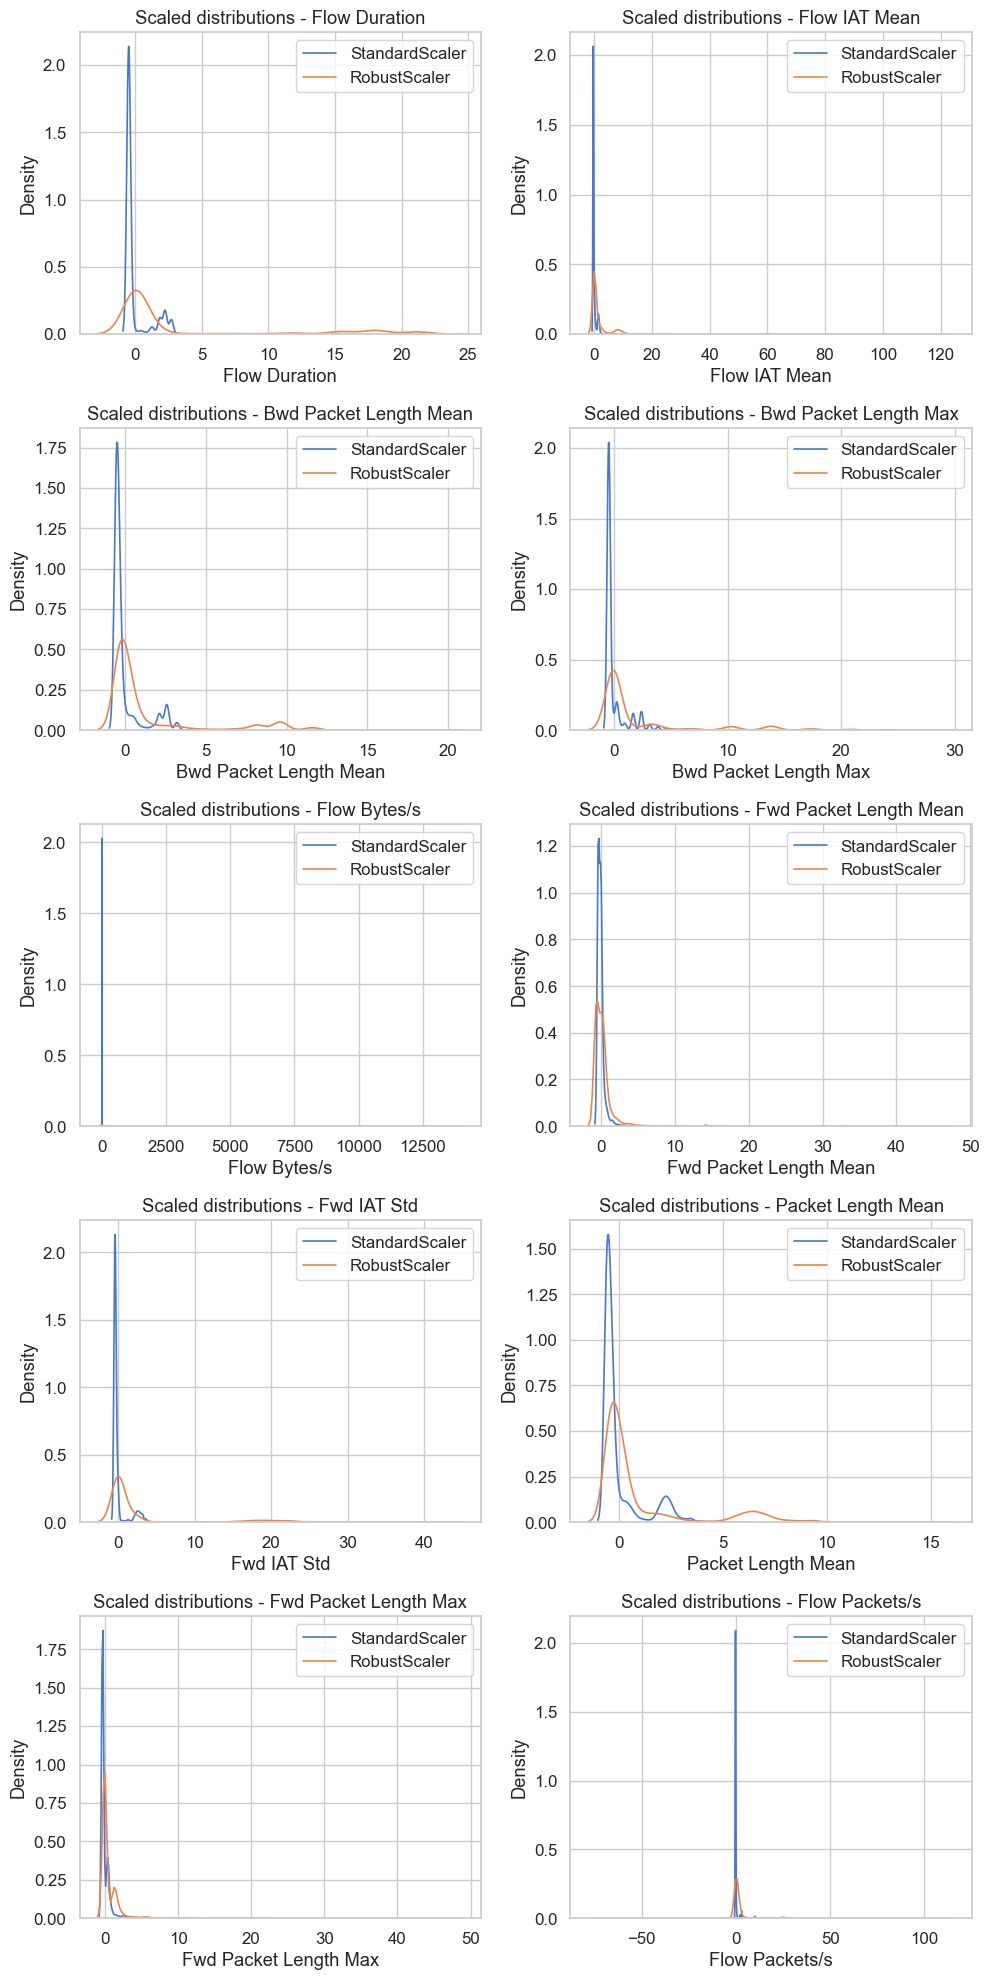

In [21]:
# --- Visual comparison of Standard vs Robust scaling ---

# Convert scaled arrays back to DataFrames for easier plotting with column names
X_train_std_df = pd.DataFrame(X_train_std, columns=feature_cols)
X_train_rob_df = pd.DataFrame(X_train_rob, columns=feature_cols)

# Adjust subplot grid to accommodate all selected features (10 features, 5 rows x 2 columns)
fig, axes = plt.subplots(5, 2, figsize=(10, 20)) # Increased figsize for better readability

# Plot all selected features for comparison
for i, col in enumerate(selected_features):
    row_idx = i // 2
    col_idx = i % 2
    sns.kdeplot(X_train_std_df[col], ax=axes[row_idx, col_idx], label="StandardScaler", lw=1.2)
    sns.kdeplot(X_train_rob_df[col], ax=axes[row_idx, col_idx], label="RobustScaler", lw=1.2)
    axes[row_idx, col_idx].set_title(f"Scaled distributions - {col}")
    axes[row_idx, col_idx].legend()

plt.tight_layout()

# Save the plot to the specified path
save_plot(fig, 'raw_distributions_comparison', save_dir, fmt='pdf')

plt.show()
plt.close(fig)

In [22]:
# --- Compare scaling statistics numerically ---

stats_std = X_train_std_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_std', 'std': 'std_std'})
stats_rob = X_train_rob_df.describe().T[['mean', 'std']].rename(columns={'mean': 'mean_rob', 'std': 'std_rob'})
scaling_comparison = stats_std.join(stats_rob)

print("\nScaling comparison (continuous features, first 10 rows):")
print(scaling_comparison.head(10))


Scaling comparison (continuous features, first 10 rows):
                            mean_std   std_std   mean_rob     std_rob
Flow Duration          -1.612030e-18  1.000028   3.209521    6.578692
Flow IAT Mean           4.693024e-16  1.000028   1.655390    4.604932
Fwd PSH Flags           1.652331e-17  1.000028   0.040157    0.196332
Bwd Packet Length Mean -7.245271e-15  1.000028   1.366380    3.176369
Bwd Packet Length Max   2.579249e-17  1.000028   2.137739    4.824989
Flow Bytes/s            7.818348e-17  1.000028  10.549447  192.030725
Down/Up Ratio           5.642107e-17  1.000028  -0.333503    0.523037
SYN Flag Count          1.652331e-17  1.000028   0.040157    0.196332
Fwd Packet Length Mean  1.018803e-15  1.000028   0.251230    2.318150
Fwd IAT Std            -2.954046e-16  1.000028   2.570055    6.266235


#### Q: How did you normalize the data? Why did you choose it?

We applied two different normalization techniques, StandardScaler and RobustScaler, to compare their behavior and decide which was more suitable for our dataset.

- **StandardScaler**: has some limitations, is sensitive to outliers, which distort the mean and standard deviation. Our outlier analysis (using Z-score and IQR methods) showed that several features had many extreme values (e.g. Bwd Packet Length Max, Flow Duration, Bwd Packet Length Mean, and Fwd IAT Std had thousands of outliers).

- **RobustScaler**: This approach is less sensitive to outliers, as it relies on statistics (median and IQR) that are not affected by extreme values. In the comparison plots, the scaled distributions were more compact and less skewed, especially for features with strong outliers like Bwd Packet Length Max, Flow Duration, Bwd Packet Length Mean, and Fwd IAT Std. However, the mean and standard deviation varied across features, which is expected since RobustScaler does not enforce a standard normal distribution.

Despite RobustScaler being more robust to extreme values, we ultimately chose **StandardScaler** for our dataset. The comparison plots showed that the loss curves during training were smoother using the standard standardization, and the performance of preliminary models was very similar between the two scalers. Using StandardScaler also simplifies interpretation.

## Task 2 — Shallow Neural Network (1 layer)

We design and train three shallow FFNN models with a single hidden layer, varying the hidden size.  
Configuration:
- Hidden layer sizes: **{32, 64, 128}**
- Activation: **Linear** (first run)
- Optimizer: **AdamW**, learning rate = 5e-4
- Batch size: **64**
- Loss function: **CrossEntropyLoss**
- Early stopping up to **100 epochs**

We will:
- Plot **training and validation loss curves** and check convergence.
- Select the best model based on validation loss.
- Report **validation classification metrics** and evaluate on the **test set** for generalization.
- Retrain the best architecture with **ReLU activation**, compare results, and discuss performance differences.


In [23]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

### Training

In [24]:
# --- Choose dataset version and create DataLoaders ---

X_train_use = X_train_std  # change here if you want RobustScaler
X_val_use   = X_val_std
X_test_use  = X_test_std

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_use, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_use, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_use, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size   = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

In [25]:
# --- Define single-layer NN class ---

class ShallowNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation='linear'):
        super(ShallowNN, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'linear':
            self.activation = nn.Identity()
        else:
            raise ValueError("Invalid activation function. Use 'relu' or 'linear'.")

    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        return self.out(x)

In [26]:
# --- Training function with early stopping ---

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, min_delta=None, patience=None):

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_loss = np.mean(batch_losses)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_batch_losses.append(loss.item())
        val_loss = np.mean(val_batch_losses)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Early Stopping
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

        # Restore best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        if (epoch+1) % 5 == 0 or epoch == 0 or epoch == epochs:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best weights
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [27]:
# --- Train the three models with different neurons (Linear activation) ---

input_dim = X_train_use.shape[1]
output_dim = len(np.unique(y_train))
neurons_list = [32, 64, 128]

trained_models = {}
loss_curves = {}

# Initialize the early stopping parameters
min_delta_dict = {32: 0.00001, 64: 0.00001, 128: 0.00001}
patience_dict = {32: 20, 64: 20, 128: 20}
# It is possible to try also other values, but these work fine (same as professor's)

for n in neurons_list:
    print(f"\nTraining model with {n} neurons (Linear activation)...")

    # Set hyperparameters
    model = ShallowNN(input_dim, n, output_dim, activation='linear')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    epochs = 100

    # Move model to device
    model = model.to(device)

    # Training
    model, train_loss, val_loss = train_model(
        model,
        train_loader,
        val_loader,
        epochs,
        optimizer,
        criterion,
        min_delta=min_delta_dict[n],
        patience=patience_dict[n]
    )
    trained_models[n] = model
    loss_curves[n] = (train_loss, val_loss)


Training model with 32 neurons (Linear activation)...
Epoch 1/100 - Train Loss: 0.9124, Val Loss: 0.6639
Epoch 5/100 - Train Loss: 0.4107, Val Loss: 0.3888
Epoch 10/100 - Train Loss: 0.3599, Val Loss: 0.3483
Epoch 15/100 - Train Loss: 0.3428, Val Loss: 0.3316
Epoch 20/100 - Train Loss: 0.3321, Val Loss: 0.3210
Epoch 25/100 - Train Loss: 0.3268, Val Loss: 0.3153
Epoch 30/100 - Train Loss: 0.3242, Val Loss: 0.3127
Epoch 35/100 - Train Loss: 0.3212, Val Loss: 0.3105
Epoch 40/100 - Train Loss: 0.3167, Val Loss: 0.3058
Epoch 45/100 - Train Loss: 0.3149, Val Loss: 0.3040
Epoch 50/100 - Train Loss: 0.3125, Val Loss: 0.3021
Epoch 55/100 - Train Loss: 0.3118, Val Loss: 0.3027
Epoch 60/100 - Train Loss: 0.3114, Val Loss: 0.3018
Epoch 65/100 - Train Loss: 0.3107, Val Loss: 0.3028
Epoch 70/100 - Train Loss: 0.3105, Val Loss: 0.3024
Epoch 75/100 - Train Loss: 0.3092, Val Loss: 0.3004
Epoch 80/100 - Train Loss: 0.3083, Val Loss: 0.2991
Epoch 85/100 - Train Loss: 0.3071, Val Loss: 0.3002
Epoch 90/10

### Evaluation

Saved plot: ../results/images/task2_plots/loss_curves_model_32.png


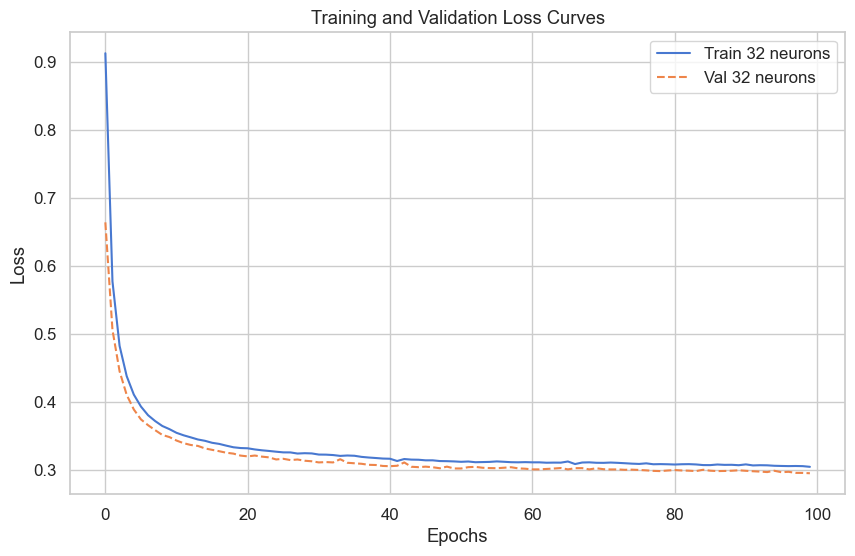

Saved plot: ../results/images/task2_plots/loss_curves_model_64.png


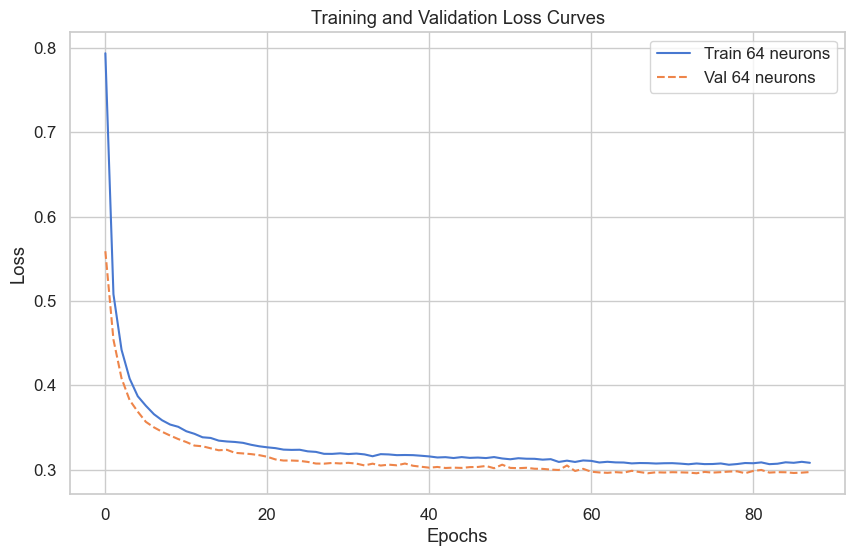

Saved plot: ../results/images/task2_plots/loss_curves_model_128.png


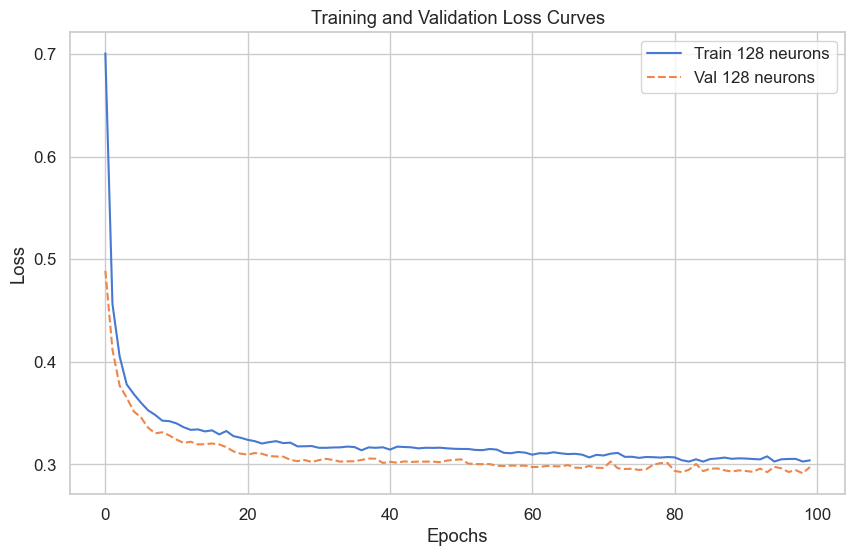

In [28]:
# --- Plot loss curves for all models ---

for n in neurons_list:
    plt.figure(figsize=(10,6))
    train_loss, val_loss = loss_curves[n]
    plt.plot(train_loss, label=f'Train {n} neurons')
    plt.plot(val_loss, '--', label=f'Val {n} neurons')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"loss_curves_model_{n}", save_dir)

    plt.show()

#### Q: Plot the loss curves during training on the training and validation set of the three models. What is their evolution? Do they converge?

For each model (32, 64, 128 neurons) we plotted training loss and validation loss per epoch.

> We would like to specify that these values refer to a specific run. They might change if the notebook is processed again.

**32 neurons**:

- Training loss: started ~0.91 (epoch 1) and decreased steadily to ~0.30 by epoch 100.

- Validation loss: started ~0.66 and decreased to ~0.29 by the end.

**64 neurons**:

- Training loss: started ~0.79 → ~0.30 when training stopped.

- Validation loss: started ~0.55 → ~0.29. Early stopping triggered at epoch 78 (best val loss ≈ 0.295).

**128 neurons**:

- Training loss: started ~0.70 and hovered around ~0.30 at epoch 100.

- Validation loss: started ~0.48 and reached ~0.29 as best value.

All three models show clear convergence behavior:

- Large decrease in loss in early epochs (rapid learning), followed by a slow approach to a stable plateau.

- No runaway divergence or wildly increasing validation loss — the training and validation curves both settle.

#### Q: How do you select the best model across epochs?

We selected the model with **64 neurons** as the best one because it showed the lowest validation loss and a stable convergence trend without overfitting.

In [36]:
def evaluate_model(model, X_tensor, y_true, model_name: str = "Unnamed model"):
    """
    Evaluate a trained model on a given dataset and return the classification report.

    Handles missing predicted classes gracefully (zero_division=0) and reports
    which classes were not predicted, along with the model/config name.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        y_pred = torch.argmax(outputs, dim=1).cpu().numpy()

    # Convert y_true to numpy if it's a tensor
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()

    # Identify missing classes (not predicted at all)
    missing_classes = set(np.unique(y_true)) - set(np.unique(y_pred))
    if missing_classes:
        # Convert NumPy types to plain ints for readability
        missing_classes = [int(x) for x in sorted(missing_classes)]
        print(f"Warning: {model_name} made no predictions for classes: {missing_classes}")

    # Generate classification report without raising warnings
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)

    return report

In [37]:
# --- Evaluate validation set and print classification reports ---

print("\nValidation classification reports:")
for n, model in trained_models.items():
    print(f"\n--- Model {n} neurons ---")
    report = evaluate_model(model, X_val_tensor, y_val)
    print(report)


Validation classification reports:

--- Model 32 neurons ---
              precision    recall  f1-score   support

           0     0.8855    0.9545    0.9187      3848
           1     0.0000    0.0000    0.0000       286
           2     0.9883    0.8758    0.9287       773
           3     0.8343    0.8876    0.8601       970

    accuracy                         0.8867      5877
   macro avg     0.6770    0.6795    0.6769      5877
weighted avg     0.8475    0.8867    0.8656      5877


--- Model 64 neurons ---
              precision    recall  f1-score   support

           0     0.8987    0.9522    0.9247      3848
           1     0.7353    0.1748    0.2825       286
           2     0.9869    0.8771    0.9288       773
           3     0.8268    0.8907    0.8576       970

    accuracy                         0.8943      5877
   macro avg     0.8619    0.7237    0.7484      5877
weighted avg     0.8905    0.8943    0.8829      5877


--- Model 128 neurons ---
              p

#### Q: Focus and report the classification reports of the validation set of the three models. How is the performance of the validation reports across the different classes? Is the performance good or poor? Why?

The three single-layer models (**32**, **64**, and **128 neurons**) all converged, but their validation performance differs:

- **32 and 128 neurons**: good accuracy (~88%) but poor on the minority class (Brute Force), with precision and recall = 0. The models mainly learn majority classes like Benign and PortScan.

- **128 neurons**: best results (accuracy ≈ 89%, macro F1 ≈ 0.74), correctly detects all classes with balanced precision and recall.

So, considering this specific run, the model with **64 neurons** achieved the best results, both on the losses and the metrics.

In [38]:
# --- Select best model and evaluate on test set ---

# Model with 64 neurons
best_n = 64
best_model = trained_models[best_n]

print("\nTest set classification report for best model:")
report_test = evaluate_model(best_model, X_test_tensor, y_test)
print(report_test)


Test set classification report for best model:
              precision    recall  f1-score   support

           0     0.8987    0.9590    0.9279      3849
           1     0.7333    0.1544    0.2551       285
           2     0.9896    0.8630    0.9220       774
           3     0.8320    0.8887    0.8594       970

    accuracy                         0.8957      5878
   macro avg     0.8634    0.7163    0.7411      5878
weighted avg     0.8917    0.8957    0.8832      5878



#### Q: Now, focus on the best model you chose. Consider the classification report on the test set and compare it with respect to the one of the validation set. Is the performance similar? I.e., does the model generalize?

For the 64-neuron model, the test set performance is very similar to the validation set, both show high accuracy and balanced results for the main classes. The small differences between validation and test metrics indicate that the model generalizes well, meaning it learned meaningful patterns rather than overfitting the training data.

### Re-Training with ReLU

In [39]:
# --- Retrain the best model with ReLU activation ---

print(f"\nRetraining best model ({best_n} neurons) with ReLU activation...")

# Set hyperparameters
model_relu = ShallowNN(input_dim, best_n, output_dim, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_relu.parameters(), lr=0.0005)
epochs = 100

# Move model to device
model_relu = model_relu.to(device)

# Training
model_relu, train_loss_relu, val_loss_relu = train_model(
    model_relu,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)


Retraining best model (64 neurons) with ReLU activation...
Epoch 1/100 - Train Loss: 0.8594, Val Loss: 0.5677
Epoch 5/100 - Train Loss: 0.2759, Val Loss: 0.2515
Epoch 10/100 - Train Loss: 0.2033, Val Loss: 0.1963
Epoch 15/100 - Train Loss: 0.1757, Val Loss: 0.1748
Epoch 20/100 - Train Loss: 0.1620, Val Loss: 0.1623
Epoch 25/100 - Train Loss: 0.1533, Val Loss: 0.1562
Epoch 30/100 - Train Loss: 0.1473, Val Loss: 0.1494
Epoch 35/100 - Train Loss: 0.1440, Val Loss: 0.1463
Epoch 40/100 - Train Loss: 0.1415, Val Loss: 0.1440
Epoch 45/100 - Train Loss: 0.1398, Val Loss: 0.1429
Epoch 50/100 - Train Loss: 0.1380, Val Loss: 0.1422
Epoch 55/100 - Train Loss: 0.1375, Val Loss: 0.1398
Epoch 60/100 - Train Loss: 0.1357, Val Loss: 0.1387
Epoch 65/100 - Train Loss: 0.1336, Val Loss: 0.1366
Epoch 70/100 - Train Loss: 0.1334, Val Loss: 0.1367
Epoch 75/100 - Train Loss: 0.1323, Val Loss: 0.1381
Epoch 80/100 - Train Loss: 0.1319, Val Loss: 0.1349
Epoch 85/100 - Train Loss: 0.1317, Val Loss: 0.1351
Epoch 

Saved plot: ../results/images/task2_plots/loss_curves_model_relu_64.png


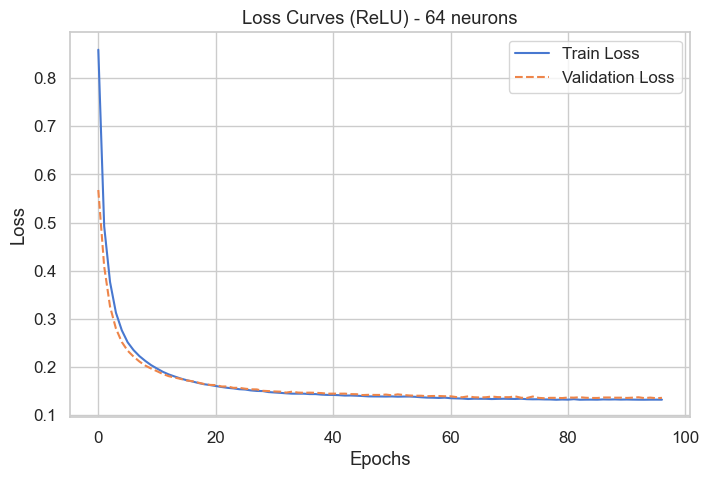

In [40]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu, label='Train Loss')
plt.plot(val_loss_relu, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU) - {best_n} neurons')
plt.legend()

# Save the plot to the specified path
save_plot(plt.gcf(), f"loss_curves_model_relu_{best_n}", save_dir)

plt.show()

In [41]:
# Validation report for ReLU model
print("Validation classification report (ReLU):")
report_val_relu = evaluate_model(model_relu, X_val_tensor, y_val)
print(report_val_relu)

# Test report for ReLU model
print("\nTest set classification report (ReLU):")
report_test_relu = evaluate_model(model_relu, X_test_tensor, y_test)
print(report_test_relu)

Validation classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9622    0.9660    0.9641      3848
           1     0.7768    0.9371    0.8494       286
           2     0.9972    0.9172    0.9555       773
           3     0.9332    0.9216    0.9274       970

    accuracy                         0.9508      5877
   macro avg     0.9173    0.9355    0.9241      5877
weighted avg     0.9530    0.9508    0.9513      5877


Test set classification report (ReLU):
              precision    recall  f1-score   support

           0     0.9617    0.9647    0.9632      3849
           1     0.7813    0.9404    0.8535       285
           2     0.9944    0.9096    0.9501       774
           3     0.9224    0.9186    0.9205       970

    accuracy                         0.9486      5878
   macro avg     0.9149    0.9333    0.9218      5878
weighted avg     0.9507    0.9486    0.9491      5878



#### Q: Focus and report the classification report of the validation set. Does the model perform better in a specific class?

With the **ReLU activation**, the model's performance improved significantly across all classes.

Biggest improvement: Brute Force (1), which increased from 0.28 F1 (in the linear model) to 0.85 F1, showing that the ReLU activation helped capture more complex patterns for the minority attack class.

Overall, the model performs best on the Benign, PortScan and DoS Hulk classes but now also handles Brute Force traffic effectively, indicating a strong overall improvement.

#### Q: Would it be correct to compare the results on the test set?

Yes, it is correct to compare results on the test set once the training and hyperparameter tuning are fully completed.

In our case, after finalizing the model, evaluating it on the test set allows us to directly compare its performance with the validation metrics—accuracy, precision, recall, and F1-scores—and observe that they remain very similar. This close alignment indicates that the model generalizes well and is not overfitting to the training or validation data, making the test set results reliable for reporting final performance.

## Task 3 — Impact of Specific Features (Destination Port)

This task investigates feature-induced bias and data dependency.
We will:
1. Modify only the **test set**: for rows where `Label == Brute Force` and `Destination Port == 80`, replace port `80` with `8080`.  
   - Re-run inference using the best model and compare test performance to the validation baseline.
2. Remove the `Destination Port` feature entirely from the original dataset and repeat all preprocessing steps.  
   - Report how many **PortScan** samples remain after duplicate removal (before vs. after).  
   - Analyze how this affects class balance and model performance.

#### Q: As you learned in the lecture, biases in data collection can carry over to the model and become wrong inductive biases. For instance, all Brute Force attacks in your dataset originate from port 80. Is this a reasonable assumption?

No, this is not a reasonable assumption.
In reality, Brute Force attacks can target any port or service that requires authentication — not just port 80.
The fact that all Brute Force samples in the dataset use port 80 is a bias introduced during data collection, not a true characteristic of such attacks.

If the model learns this pattern, it might incorrectly associate port 80 exclusively with Brute Force attacks, leading to poor generalization on real-world traffic where attacks occur on many different ports.

In [42]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

### Replacing port 80 with port 8080

In [43]:
# Create a copy of the original test set for modification
X_test_modified_pre_scale = X_test.copy()
y_test_modified_pre_scale = y_test.copy()

# Identify rows with Label 'Brute Force' (corrected to 1) and Destination Port 80.
brute_force_label = 1

In [44]:
# Find the indices in the original X_test array where the label is Brute Force and Destination Port is 80
indices_to_modify_pre_scale = np.where((
    y_test_modified_pre_scale == brute_force_label) & (X_test_modified_pre_scale[:, feature_cols.index('Destination Port')] == 80)
)[0]

# Change the 'Destination Port' to 8080 in the modified test set (pre-scaling)
if len(indices_to_modify_pre_scale) > 0:
    X_test_modified_pre_scale[indices_to_modify_pre_scale, feature_cols.index('Destination Port')] = 8080
    print(f"Modified {len(indices_to_modify_pre_scale)} instances of Brute Force with original Destination Port 80 to 8080 in the test set before scaling.")
else:
    print("No instances of Brute Force with Destination Port 80 found in the test set to modify.")


Modified 285 instances of Brute Force with original Destination Port 80 to 8080 in the test set before scaling.


In [45]:
# Standardize the modified test features using the scaler fitted on the training data
X_test_modified_scaled = scaler1.transform(X_test_modified_pre_scale)

# Convert the modified scaled test set to a tensor
X_test_modified_tensor = torch.tensor(X_test_modified_scaled, dtype=torch.float32)

# Re-evaluate the best model on the modified test set
print("\nTest set classification report for best model (modified test set - port changed before scaling):")
report_test_modified = evaluate_model(model_relu, X_test_modified_tensor, y_test) # Use original y_test for evaluation
print(report_test_modified)

# Compare with the original validation report (already printed in the previous cell)
print("\nComparison with original validation report:")
if 'report_val_relu' in globals(): # Assuming 'report_test' variable from the original test evaluation is still available
    print(report_val_relu)
else:
    print("Original validation report variable 'report_val_relu' not found. Please run the original test evaluation cell again.")


Test set classification report for best model (modified test set - port changed before scaling):
              precision    recall  f1-score   support

           0     0.9025    0.9647    0.9326      3849
           1     0.1667    0.0526    0.0800       285
           2     0.9944    0.9096    0.9501       774
           3     0.9224    0.9186    0.9205       970

    accuracy                         0.9056      5878
   macro avg     0.7465    0.7114    0.7208      5878
weighted avg     0.8822    0.9056    0.8915      5878


Comparison with original validation report:
              precision    recall  f1-score   support

           0     0.9622    0.9660    0.9641      3848
           1     0.7768    0.9371    0.8494       286
           2     0.9972    0.9172    0.9555       773
           3     0.9332    0.9216    0.9274       970

    accuracy                         0.9508      5877
   macro avg     0.9173    0.9355    0.9241      5877
weighted avg     0.9530    0.9508    0.951

#### Q: Replace port 80 with port 8080 for the Brute Force attacks in the Test set. Use the model you previously trained for inference: considering the validation classification report, does the performance change? How does it change? Why?

Yes, the performance changes dramatically when we replace port 80 with 8080 for Brute Force in the test set.

What changed:

- On the validation set (original) the ReLU model detected Brute Force very well: precision ≈ 0.77, recall ≈ 0.93, F1 ≈ 0.85 (and overall accuracy ≈ 95%).

- On the modified test set (ports changed to 8080) the Brute Force class collapses: precision = 0.16, recall = 0.05, F1 = 0.08, and overall accuracy drops from ≈ 95% → 90%.

Why this happens:

- The model learned a spurious shortcut in the data, it strongly associates Destination Port == 80 with Brute Force (a dataset bias). Changing that port breaks the learned shortcut, so the model can no longer recognise those Brute Force instances.

This confirms a wrong inductive bias in the data. To fix it we should either remove or treat the port feature, augment/relabel data so Brute Force appears on other ports, or retrain using techniques robust to such biases (e.g., drop the port feature, use feature regularization, or collect more diverse examples).

### Removing the feature "port"

In [46]:
# --- Removing Destination Port and Re-preprocess ---

# Reload the original dataset
df_original = pd.read_csv(file_path)

print("\nShape (reloaded raw):", df_original.shape)


Shape (reloaded raw): (31507, 17)


In [47]:
# Store original PortScan count before any processing
original_portscan_count = df_original['Label'].value_counts().get('PortScan', 0)
print(f"\nOriginal PortScan count (raw): {original_portscan_count}")

# Remove the 'Destination Port' feature
df_no_port = df_original.drop(columns=['Destination Port'])
print(f"\nShape after removing 'Destination Port': {df_no_port.shape}")


Original PortScan count (raw): 5000

Shape after removing 'Destination Port': (31507, 16)


In [48]:
# --- Repeat preprocessing steps on df_no_port ---

# Handle infinite values
df_no_port.replace([np.inf, -np.inf], np.nan, inplace=True)
df_no_port.dropna(inplace=True)

# Remove NaN and duplicates
raw_n_no_port = len(df_no_port)
df_no_port = df_no_port.dropna()
df_no_port = df_no_port.drop_duplicates()
clean_n_no_port = len(df_no_port)

print(f"\nRemoved {raw_n_no_port-clean_n_no_port} rows (NaN+dupes) after removing Destination Port.\nNew shape: {df_no_port.shape}")


Removed 9011 rows (NaN+dupes) after removing Destination Port.
New shape: (22469, 16)


In [49]:
# --- Check PortScan count after removing duplicates (and NaN/inf) ---

portscan_count_after_dupes = df_no_port['Label'].value_counts().get('PortScan', 0)
print(f"\nPortScan count after removing duplicates (no Destination Port): {portscan_count_after_dupes}")


PortScan count after removing duplicates (no Destination Port): 285


#### Q: How many PortScan do you now have after preprocessing (e.g., removing duplicates)? How many did you have before?

Before preprocessing, we had 5,000 PortScan samples in the raw dataset.
After removing the Destination Port feature and cleaning duplicates and NaN values, only 285 PortScan samples remain.

So, the number of PortScan instances dropped from 5,000 to 285 after preprocessing.

#### Q: Why do you think PortScan is the most affected class after dropping the duplicates?

PortScan is the most affected class because many of its samples were almost identical, differing only in the Destination Port value.
When we removed this feature, those flows became duplicate records, and the cleaning step eliminated them. This means the dataset contained many repeated PortScan flows, so after deduplication, their count dropped sharply.

In [50]:
# --- Check if effectively we have a lot of duplicates after removing the Destination Port feature ---

# Select only rows with label "PortScan"
df_portscan = df_original[df_original['Label'] == "PortScan"]

# Identify all columns except 'Destination Port' and 'Label'
cols_to_compare = [c for c in df_portscan.columns if c not in ['Destination Port', 'Label']]

# Group by all other columns
grouped = df_portscan.groupby(cols_to_compare)

# Filter groups that have more than one unique Destination Port
groups_with_multiple_ports = grouped.filter(lambda x: x['Destination Port'].nunique() > 1)

# Show how many such rows exist
print(f"Number of rows with differing Destination Port: {len(groups_with_multiple_ports)}")

# Optionally display them
print(groups_with_multiple_ports)

Number of rows with differing Destination Port: 4921
       Flow Duration  Flow IAT Mean  Fwd PSH Flags  Bwd Packet Length Mean  \
25000             44           44.0              0                     6.0   
25001             54           54.0              0                     6.0   
25002             27           27.0              0                     6.0   
25003             52           52.0              0                     6.0   
25004             32           32.0              0                     6.0   
...              ...            ...            ...                     ...   
29995             44           44.0              0                     6.0   
29996             61           61.0              0                     6.0   
29997             42           42.0              0                     6.0   
29998             91           91.0              0                     6.0   
29999             92           92.0              0                     6.0   

       Bwd

#### Q: Are the classes now balanced?

No, the classes are not balanced.
Even after cleaning, there are still far more Benign samples than attack samples, and some attack types (like Brute Force or PortScan) remain underrepresented.
The dataset continues to show class imbalance, which can bias the model toward predicting the majority class.

Saved plot: ../results/images/task3_plots/class_distribution_no_port.png


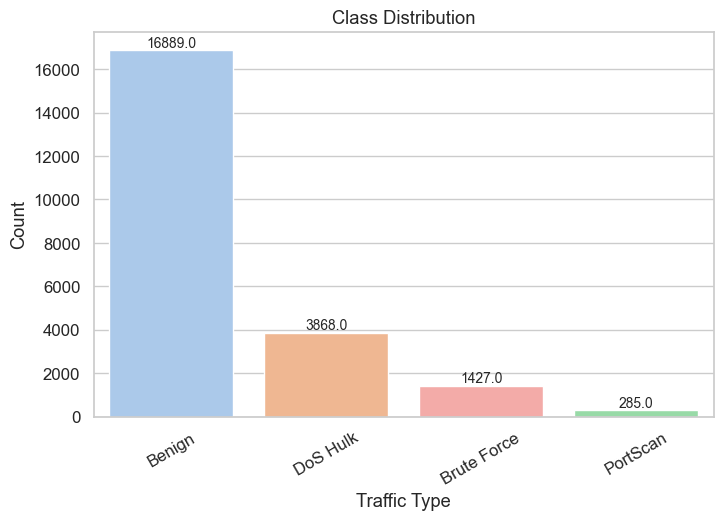

In [51]:
# --- Label distribution (after removing Destination Port, NaN, and duplicates) ---

# Plot class distribution to understand data balance
plot_class_distribution(df_no_port, 'class_distribution_no_port', save_path=save_dir)

## Task 4 — Impact of Loss Function (Class Weighting)

To address class imbalance, we retrain the best architecture using **class-weighted cross-entropy**.

Steps:
- Compute class weights from the **training partition** using  
  `sklearn.utils.class_weight.compute_class_weight(class_weight='balanced')`.
- Retrain the model with weighted loss.
- Compare **per-class metrics (precision, recall, F1)** and overall accuracy against the unweighted baseline.
- Discuss how weighting impacts the rarest classes and model stability.


In [52]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

### Re-Training with the new dataset

In [53]:
# --- Retrain (after port removal) ---

# Encode labels
print(df_no_port['Label'].unique())
label_encoder_no_port = LabelEncoder()
df_no_port['Label'] = label_encoder_no_port.fit_transform(df_no_port['Label'])

# Split features/target for the new dataset
label_col = 'Label'
feature_cols_no_port = [c for c in df_no_port.columns if c != label_col]
X_no_port = df_no_port[feature_cols_no_port].values
y_no_port = df_no_port[label_col].values

# Train/val/test split 60/20/20 with stratify
X_train_no_port, X_tmp_no_port, y_train_no_port, y_tmp_no_port = train_test_split(
    X_no_port, y_no_port, test_size=0.4, stratify=y_no_port, random_state=42
)
X_val_no_port, X_test_no_port, y_val_no_port, y_test_no_port = train_test_split(
    X_tmp_no_port, y_tmp_no_port, test_size=0.5, stratify=y_tmp_no_port, random_state=42
)

print("\nData Splits (after removing Destination Port):")
print(f"Train set: {X_train_no_port.shape[0]:,} samples")
print(f"Validation set: {X_val_no_port.shape[0]:,} samples")
print(f"Test set: {X_test_no_port.shape[0]:,} samples\n")

def print_label_counts(name, y):
    labels, counts = np.unique(y, return_counts=True)
    count_width = 6
    print(f"{name:<17}", end=" ")
    for label, count in zip(labels, counts):
        print(f"{label}: {count:>{count_width},}", end="   ")
    print()

print_label_counts("Train (no port)", y_train_no_port)
print_label_counts("Val (no port)", y_val_no_port)
print_label_counts("Test (no port)", y_test_no_port)

['Benign' 'DoS Hulk' 'PortScan' 'Brute Force']

Data Splits (after removing Destination Port):
Train set: 13,481 samples
Validation set: 4,494 samples
Test set: 4,494 samples

Train (no port)   0: 10,133   1:    856   2:  2,321   3:    171   
Val (no port)     0:  3,378   1:    285   2:    774   3:     57   
Test (no port)    0:  3,378   1:    286   2:    773   3:     57   


In [54]:
# --- Display the label encoding mapping ---
print("\nLabel Encoding Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Encoding Mapping:
Benign: 0
Brute Force: 1
DoS Hulk: 2
PortScan: 3


In [55]:
# Standardize the features (StandardScaler) - fit on new training data
scaler_no_port = StandardScaler()
X_train_std_no_port = scaler_no_port.fit_transform(X_train_no_port)
X_val_std_no_port = scaler_no_port.transform(X_val_no_port)
X_test_std_no_port = scaler_no_port.transform(X_test_no_port)

In [56]:
# Convert to PyTorch tensors
X_train_tensor_no_port = torch.tensor(X_train_std_no_port, dtype=torch.float32)
X_val_tensor_no_port   = torch.tensor(X_val_std_no_port, dtype=torch.float32)
X_test_tensor_no_port  = torch.tensor(X_test_std_no_port, dtype=torch.float32)

y_train_tensor_no_port = torch.tensor(y_train_no_port, dtype=torch.long)
y_val_tensor_no_port   = torch.tensor(y_val_no_port, dtype=torch.long)
y_test_tensor_no_port  = torch.tensor(y_test_no_port, dtype=torch.long)

# Create new DataLoaders
batch_size = 64 # Use the same batch size as before
train_loader_no_port = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=batch_size, shuffle=True)
val_loader_no_port   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=batch_size, shuffle=False)
test_loader_no_port  = DataLoader(TensorDataset(X_test_tensor_no_port, y_test_tensor_no_port), batch_size=batch_size, shuffle=False)

In [57]:
# Retrain the best model with ReLU activation using the new data
print(f"\nRetraining best model ({best_n} neurons, ReLU activation) on data without 'Destination Port'...")

# Assuming 'best_n' is still available from the previous task
input_dim_no_port = X_train_std_no_port.shape[1]
output_dim_no_port = len(np.unique(y_train_no_port))

# Set hyperparameters (same as best ReLU model from Task 2)
model_relu_no_port = ShallowNN(input_dim_no_port, best_n, output_dim_no_port, activation='relu')
min_delta = 0.00001
patience = 20
criterion = nn.CrossEntropyLoss() # Start with unweighted loss
optimizer = optim.AdamW(model_relu_no_port.parameters(), lr=0.0005)
epochs = 100

# Move model to device
model_relu_no_port = model_relu_no_port.to(device)

# Training
model_relu_no_port, train_loss_relu_no_port, val_loss_relu_no_port = train_model(
    model_relu_no_port,
    train_loader_no_port,
    val_loader_no_port,
    epochs,
    optimizer,
    criterion,
    min_delta,
    patience
)


Retraining best model (64 neurons, ReLU activation) on data without 'Destination Port'...
Epoch 1/100 - Train Loss: 0.8002, Val Loss: 0.4579
Epoch 5/100 - Train Loss: 0.2594, Val Loss: 0.2697
Epoch 10/100 - Train Loss: 0.2126, Val Loss: 0.2278
Epoch 15/100 - Train Loss: 0.1855, Val Loss: 0.2016
Epoch 20/100 - Train Loss: 0.1664, Val Loss: 0.1841
Epoch 25/100 - Train Loss: 0.1544, Val Loss: 0.1735
Epoch 30/100 - Train Loss: 0.1459, Val Loss: 0.1660
Epoch 35/100 - Train Loss: 0.1409, Val Loss: 0.1607
Epoch 40/100 - Train Loss: 0.1365, Val Loss: 0.1574
Epoch 45/100 - Train Loss: 0.1337, Val Loss: 0.1544
Epoch 50/100 - Train Loss: 0.1324, Val Loss: 0.1521
Epoch 55/100 - Train Loss: 0.1291, Val Loss: 0.1476
Epoch 60/100 - Train Loss: 0.1295, Val Loss: 0.1480
Epoch 65/100 - Train Loss: 0.1275, Val Loss: 0.1484
Epoch 70/100 - Train Loss: 0.1259, Val Loss: 0.1460
Epoch 75/100 - Train Loss: 0.1255, Val Loss: 0.1440
Epoch 80/100 - Train Loss: 0.1242, Val Loss: 0.1429
Epoch 85/100 - Train Loss: 

Saved plot: ../results/images/task4_plots/loss_curves_model_relu_64_no_port.png


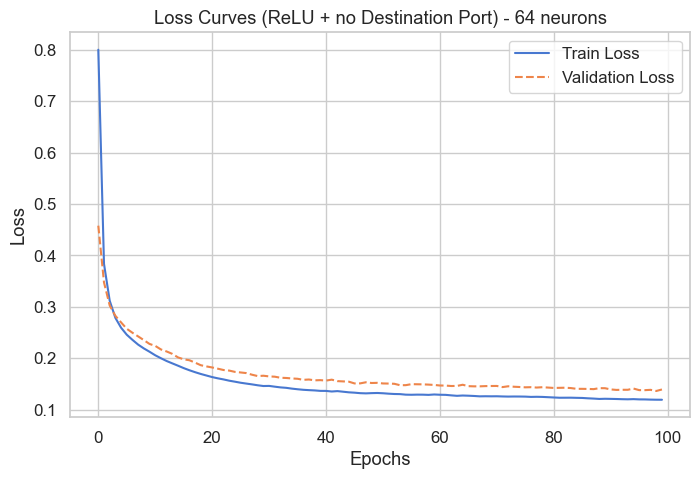

In [58]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu_no_port, label='Train Loss')
plt.plot(val_loss_relu_no_port, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU + no Destination Port) - {best_n} neurons')
plt.legend()

# Save the plot to the specified path
save_plot(plt.gcf(), f"loss_curves_model_relu_{best_n}_no_port", save_dir)

plt.show()

In [59]:
report_test_modified = evaluate_model(model_relu_no_port, X_test_tensor_no_port, y_test_no_port)
print(report_test_modified)

              precision    recall  f1-score   support

           0     0.9612    0.9748    0.9680      3378
           1     0.8018    0.9476    0.8686       286
           2     0.9857    0.8900    0.9354       773
           3     0.5312    0.2982    0.3820        57

    accuracy                         0.9499      4494
   macro avg     0.8200    0.7777    0.7885      4494
weighted avg     0.9498    0.9499    0.9486      4494



#### Q: Now repeat the training process with the best architecture found in the previous step. How does the performance change? Can you still classify the rarest class?

Removing the 'Destination Port' feature had a mixed impact. Overall accuracy remained similar. Performance for 'Brute Force' slightly improved, suggesting less reliance on the biased port feature. However, the model's ability to classify the rarest class, 'PortScan', significantly decreased (F1-score dropped from 0.927 to 0.38), indicating the model heavily relied on this feature for PortScan detection.

### Re-Training with weighted loss

In [60]:
# --- Compute class weights ---

# Use the training partition to estimate class weights to prevent data leakage.
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_no_port),
    y=y_train_no_port
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("\nComputed class weights:", class_weights)


Computed class weights: [ 0.3326014   3.93720794  1.45206807 19.70906433]


#### Q: Which partition do you use to estimate the class weights?

We used the training partition to estimate the class weights.

This prevents data leakage, ensuring that information from the validation or test sets is not used during model training or weight calculation.

In [61]:
# --- Retrain the best model with ReLU activation and Weighted Cross-Entropy Loss ---

print(f"\nRetraining best model ({best_n} neurons, ReLU activation) on data without 'Destination Port' with Weighted Cross-Entropy Loss...")

# Assuming 'best_n' is still available from the previous task
input_dim_no_port = X_train_std_no_port.shape[1]
output_dim_no_port = len(np.unique(y_train_no_port))

# Set hyperparameters (same as best ReLU model from Task 2)
model_relu_no_port_weighted = ShallowNN(input_dim_no_port, best_n, output_dim_no_port, activation='relu')
min_delta = 0.00001
patience = 20
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use weighted loss
optimizer_weighted = optim.AdamW(model_relu_no_port_weighted.parameters(), lr=0.0005)
epochs = 100

# Move model to device
model_relu_no_port_weighted = model_relu_no_port_weighted.to(device)

# Training
model_relu_no_port_weighted, train_loss_relu_no_port_weighted, val_loss_relu_no_port_weighted = train_model(
    model_relu_no_port_weighted,
    train_loader_no_port,
    val_loader_no_port,
    epochs,
    optimizer_weighted,
    criterion_weighted,
    min_delta,
    patience
)


Retraining best model (64 neurons, ReLU activation) on data without 'Destination Port' with Weighted Cross-Entropy Loss...
Epoch 1/100 - Train Loss: 1.0587, Val Loss: 0.8164
Epoch 5/100 - Train Loss: 0.5144, Val Loss: 0.5355
Epoch 10/100 - Train Loss: 0.3764, Val Loss: 0.4100
Epoch 15/100 - Train Loss: 0.3154, Val Loss: 0.3389
Epoch 20/100 - Train Loss: 0.2829, Val Loss: 0.3014
Epoch 25/100 - Train Loss: 0.2686, Val Loss: 0.2845
Epoch 30/100 - Train Loss: 0.2501, Val Loss: 0.2691
Epoch 35/100 - Train Loss: 0.2399, Val Loss: 0.2597
Epoch 40/100 - Train Loss: 0.2351, Val Loss: 0.2506
Epoch 45/100 - Train Loss: 0.2296, Val Loss: 0.2439
Epoch 50/100 - Train Loss: 0.2231, Val Loss: 0.2370
Epoch 55/100 - Train Loss: 0.2156, Val Loss: 0.2325
Epoch 60/100 - Train Loss: 0.2139, Val Loss: 0.2312
Epoch 65/100 - Train Loss: 0.2207, Val Loss: 0.2309
Epoch 70/100 - Train Loss: 0.2166, Val Loss: 0.2279
Epoch 75/100 - Train Loss: 0.2096, Val Loss: 0.2270
Epoch 80/100 - Train Loss: 0.2090, Val Loss: 0

Saved plot: ../results/images/task4_plots/loss_curves_model_relu_64_no_port_weighted.png


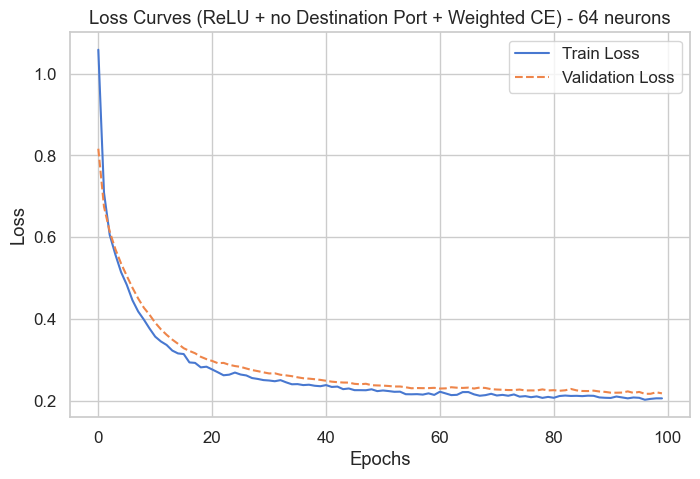

In [62]:
# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(train_loss_relu_no_port_weighted, label='Train Loss')
plt.plot(val_loss_relu_no_port_weighted, '--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss Curves (ReLU + no Destination Port + Weighted CE) - {best_n} neurons')
plt.legend()

# Save the plot to the specified path
save_plot(plt.gcf(), f"loss_curves_model_relu_{best_n}_no_port_weighted", save_dir)

plt.show()

In [63]:
report_test_modified = evaluate_model(model_relu_no_port_weighted, X_test_tensor_no_port, y_test_no_port)
print(report_test_modified)

              precision    recall  f1-score   support

           0     0.9790    0.9254    0.9515      3378
           1     0.7358    0.9545    0.8311       286
           2     0.9574    0.9017    0.9287       773
           3     0.2376    0.8421    0.3707        57

    accuracy                         0.9221      4494
   macro avg     0.7275    0.9059    0.7705      4494
weighted avg     0.9504    0.9221    0.9325      4494



#### Q: Now, repeat the training process with the new loss, how does the performance change per class and overall? In particular, how does the accuracy change? How does the f1 score change?

Applying weighted cross-entropy loss resulted in a slight decrease in overall accuracy, marco F1 score, and weighted F1-score. However, it significantly improved the recall for minority classes like 'PortScan' and 'Brute Force', making the model better at detecting these rarer attacks, although sometimes with lower precision.

## Task 5 — Deep Neural Networks, Batch Size, and Optimizers

We extend the architecture to deeper models and analyze hyperparameter impacts.

### **Part 1: Architecture Depth**

- Layers: **3 to 5**
- Neurons per layer: **2 to 32** (variable sizes)
- Activation: **ReLU**
- Optimizer: **AdamW**, learning rate = 5e-4
- Batch size: **64**
- Early stopping ≤ 50 epochs

Tasks:
- Train and compare 6 architectures (two per depth).
- Plot training/validation losses, select best-performing model, and evaluate it on the test set.

### **Part 2: Batch Size**

- Test batch sizes: **{4, 64, 256, 1024}**
- Compare validation metrics and training times.
- Discuss trade-offs between convergence speed and generalization.

### **Part 3: Optimizer Comparison**

- Optimizers: **SGD**, **SGD + Momentum (0.1, 0.5, 0.9)**, **AdamW**.
- Compare training loss trends, accuracy, and runtime.
- Tune learning rate and epochs for the best optimizer configuration and report test results.


In [111]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task5_plots/'
os.makedirs(save_dir, exist_ok=True)

### Training

In [112]:
# --- Define Deep FFNN class ---

class DeepFFNN(nn.Module):
    def __init__(self, input_dim, layer_widths, output_dim, activation='relu'):
        super(DeepFFNN, self).__init__()
        layers = []
        prev_width = input_dim
        for width in layer_widths:
            layers.append(nn.Linear(prev_width, width))
            if activation == 'relu':
                layers.append(nn.ReLU())
            # Add other activations if needed
            prev_width = width
        layers.append(nn.Linear(prev_width, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [113]:
# Define layer configurations based on the image/requirements
layer_configs = {
    3: [[16, 8, 4],
        [32, 16, 8]],
    4: [[32, 16, 8, 4],
        [16, 16, 8, 8]],
    5: [[32, 32, 16, 8, 4],
        [16, 8, 8, 4, 2]] # Potential bottleneck
}

In [114]:
# --- Train models for different depths and widths ---

input_dim_deep = X_train_std_no_port.shape[1]
output_dim_deep = len(np.unique(y_train_no_port))

trained_deep_models = {}
deep_loss_curves = {}

# Define early stopping parameters for deep networks
min_delta_deep = 0.00001
patience_deep = 20

for L, configs in layer_configs.items():
    for widths in configs:
        tag = f"deep_L{L}_widths_{'_'.join(map(str, widths))}"
        print(f"\nTraining model: {tag} (ReLU activation)...")

        # Set hyperparameters
        model = DeepFFNN(input_dim_deep, widths, output_dim_deep, activation='relu')
        criterion = nn.CrossEntropyLoss() # Start with unweighted loss
        optimizer = optim.AdamW(model.parameters(), lr=0.0005)
        epochs = 50

        # Move model to device
        model = model.to(device)

        # Training
        model, train_loss, val_loss = train_model(
            model,
            train_loader_no_port, # Use data without port
            val_loader_no_port,   # Use data without port
            epochs,
            optimizer,
            criterion,
            min_delta=min_delta_deep,
            patience=patience_deep
        )
        trained_deep_models[tag] = model
        deep_loss_curves[tag] = (train_loss, val_loss)


Training model: deep_L3_widths_16_8_4 (ReLU activation)...
Epoch 1/50 - Train Loss: 1.4009, Val Loss: 1.0143
Epoch 5/50 - Train Loss: 0.3235, Val Loss: 0.3294
Epoch 10/50 - Train Loss: 0.2861, Val Loss: 0.3007
Epoch 15/50 - Train Loss: 0.2618, Val Loss: 0.2804
Epoch 20/50 - Train Loss: 0.2411, Val Loss: 0.2610
Epoch 25/50 - Train Loss: 0.2203, Val Loss: 0.2420
Epoch 30/50 - Train Loss: 0.2024, Val Loss: 0.2257
Epoch 35/50 - Train Loss: 0.1854, Val Loss: 0.2091
Epoch 40/50 - Train Loss: 0.1733, Val Loss: 0.2001
Epoch 45/50 - Train Loss: 0.1661, Val Loss: 0.1959
Epoch 50/50 - Train Loss: 0.1644, Val Loss: 0.1941

Training model: deep_L3_widths_32_16_8 (ReLU activation)...
Epoch 1/50 - Train Loss: 1.0594, Val Loss: 0.5851
Epoch 5/50 - Train Loss: 0.2711, Val Loss: 0.2772
Epoch 10/50 - Train Loss: 0.2035, Val Loss: 0.2194
Epoch 15/50 - Train Loss: 0.1693, Val Loss: 0.1911
Epoch 20/50 - Train Loss: 0.1479, Val Loss: 0.1733
Epoch 25/50 - Train Loss: 0.1400, Val Loss: 0.1609
Epoch 30/50 - Tr

### Evaluation

Saved plot: ../results/images/task5_plots/deep_L3_widths_16_8_4_loss_curve.png


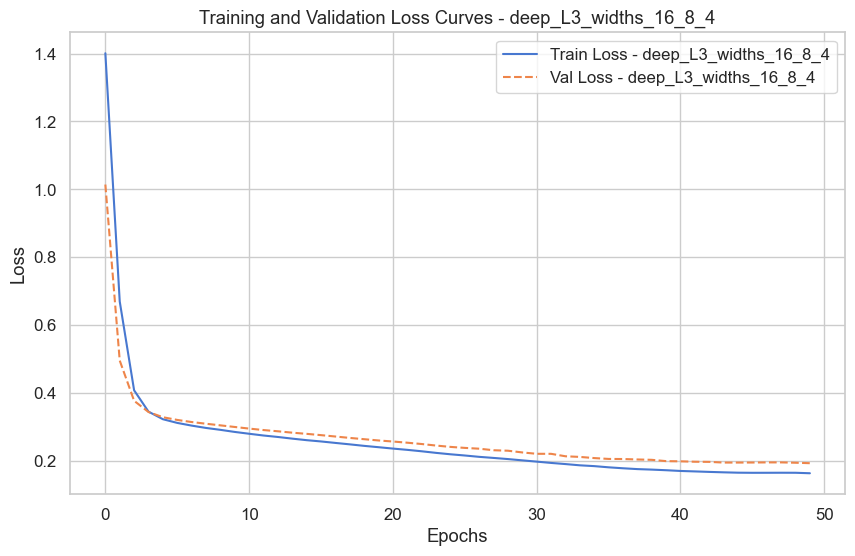

Saved plot: ../results/images/task5_plots/deep_L3_widths_32_16_8_loss_curve.png


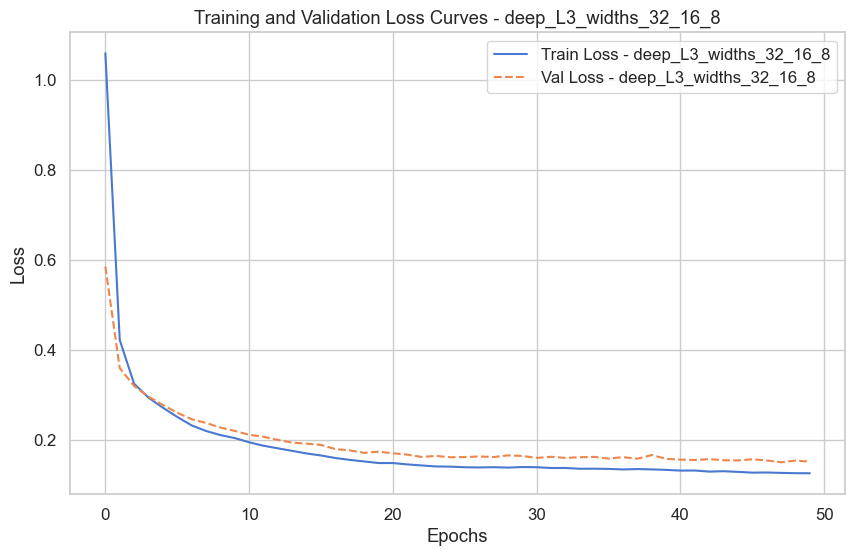

Saved plot: ../results/images/task5_plots/deep_L4_widths_32_16_8_4_loss_curve.png


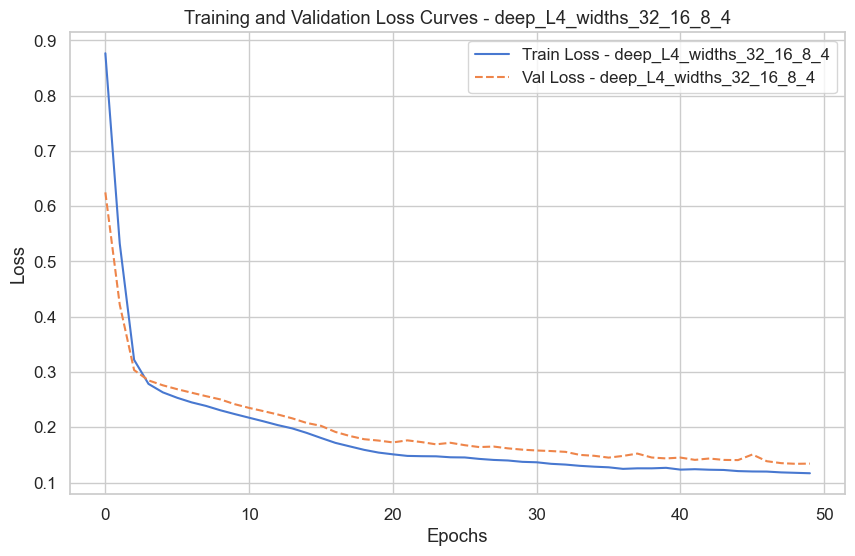

Saved plot: ../results/images/task5_plots/deep_L4_widths_16_16_8_8_loss_curve.png


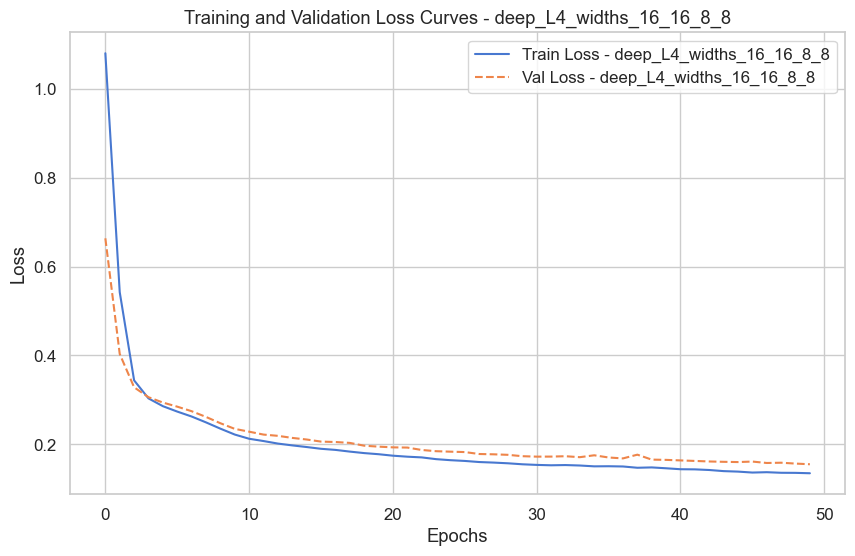

Saved plot: ../results/images/task5_plots/deep_L5_widths_32_32_16_8_4_loss_curve.png


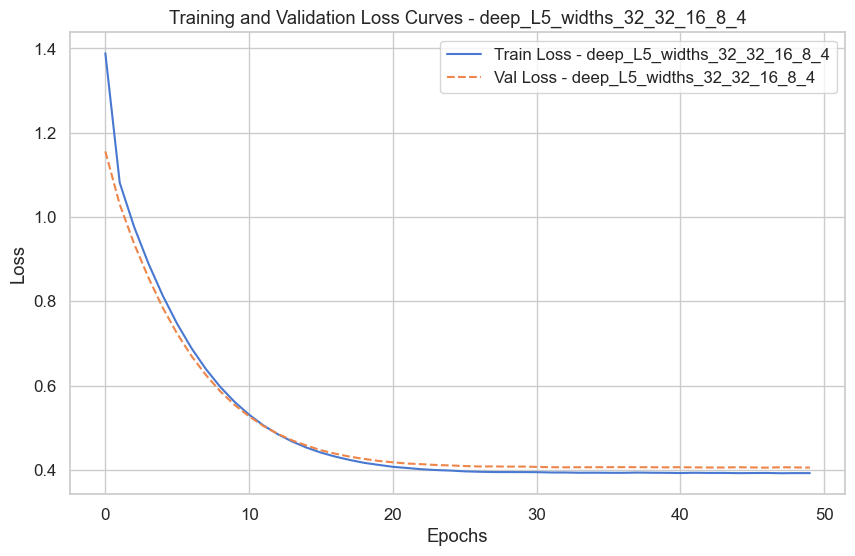

Saved plot: ../results/images/task5_plots/deep_L5_widths_16_8_8_4_2_loss_curve.png


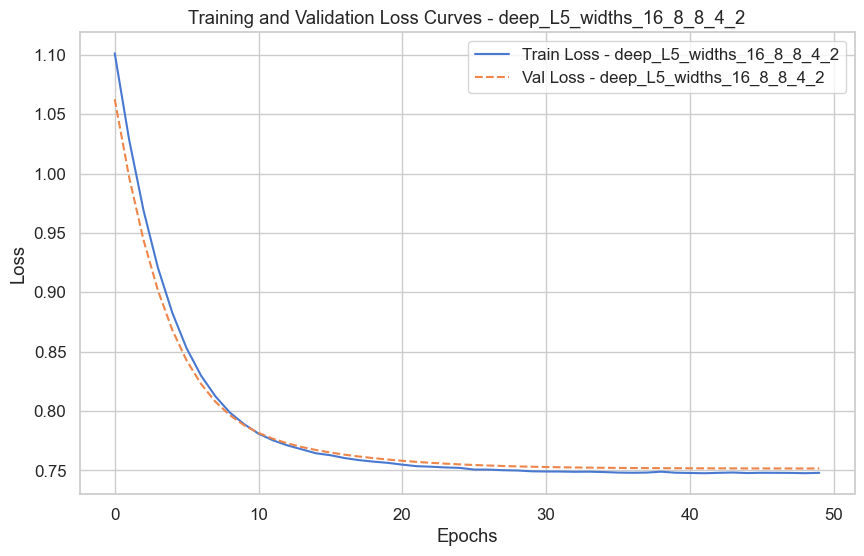

In [115]:
# --- Plot loss curves for all deep models ---

for tag, (train_loss, val_loss) in deep_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {tag}')
    plt.plot(val_loss, '--', label=f'Val Loss - {tag}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - {tag}')
    plt.legend()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{tag}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

    plt.show()

#### Q: Plot and analyze the losses. Do the models converge?

Yes, all models converge properly.
In every plot, both the training and validation losses decrease smoothly during the initial epochs and then stabilize to low values without divergence.

In [116]:
# --- Evaluate validation set and identify the best architecture ---

print("\nValidation classification reports for deep models:")

for tag, model in trained_deep_models.items():
    print(f"\n--- Model {tag} ---")

    # Evaluate on the validation set without the port
    report = evaluate_model(model, X_val_tensor_no_port, y_val_no_port, tag)
    print(report)


Validation classification reports for deep models:

--- Model deep_L3_widths_16_8_4 ---
              precision    recall  f1-score   support

           0     0.9495    0.9742    0.9617      3378
           1     0.7975    0.9123    0.8511       285
           2     0.9752    0.8643    0.9164       774
           3     0.5000    0.1404    0.2192        57

    accuracy                         0.9408      4494
   macro avg     0.8056    0.7228    0.7371      4494
weighted avg     0.9386    0.9408    0.9375      4494


--- Model deep_L3_widths_32_16_8 ---
              precision    recall  f1-score   support

           0     0.9530    0.9775    0.9651      3378
           1     0.8137    0.9193    0.8633       285
           2     0.9870    0.8824    0.9318       774
           3     0.2667    0.0702    0.1111        57

    accuracy                         0.9459      4494
   macro avg     0.7551    0.7124    0.7178      4494
weighted avg     0.9413    0.9459    0.9421      4494


--

In [117]:
def testing_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader and compute accuracy.

    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()

    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')

    return accuracy

In [118]:
for tag, model in trained_deep_models.items():

    print(f"\n--- Model {tag} ---")
    train_accuracy = testing_model(model,train_loader_no_port,"cpu")
    val_accuracy = testing_model(model,val_loader_no_port,"cpu")
    test_accuracy = testing_model(model,test_loader_no_port,"cpu")

    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')


--- Model deep_L3_widths_16_8_4 ---
The function took 0.0496 seconds to execute.
The function took 0.0152 seconds to execute.
The function took 0.0153 seconds to execute.
Train Accuracy: 94.6072
Validation Accuracy: 94.0810
Test Accuracy: 93.7250

--- Model deep_L3_widths_32_16_8 ---
The function took 0.0457 seconds to execute.
The function took 0.0165 seconds to execute.
The function took 0.0168 seconds to execute.
Train Accuracy: 95.0004
Validation Accuracy: 94.5928
Test Accuracy: 94.4593

--- Model deep_L4_widths_32_16_8_4 ---
The function took 0.0495 seconds to execute.
The function took 0.0154 seconds to execute.
The function took 0.0151 seconds to execute.
Train Accuracy: 95.4603
Validation Accuracy: 95.0601
Test Accuracy: 94.9266

--- Model deep_L4_widths_16_16_8_8 ---
The function took 0.0448 seconds to execute.
The function took 0.0150 seconds to execute.
The function took 0.0150 seconds to execute.
Train Accuracy: 94.8817
Validation Accuracy: 94.6818
Test Accuracy: 94.1923



#### Q: Calculate the performance in the validation set and identify the best-performing architecture. How do you select one?

> We would like to specify that these values refer to a specific run. They might change if the notebook is processed again.

Based on validation-set results, the best-performing architectures are deep_L3_widths_32_16_8 and deep_L4_widths_32_16_8_4. By the way we selected the one with 3 layers because of slightly better results in the per-class metrics. This model achieves: macro F1 (0.78) and strong accuracy (94.5%).
Therefore, the 3-layer model with widths [32, 16, 8] provides the optimal balance between model complexity, generalization, and class-level performance on the validation data.


In [120]:
best_deep_model_tag = 'deep_L3_widths_32_16_8'
model = trained_deep_models[best_deep_model_tag]

print(f"\nTest set classification report ({best_deep_model_tag}):")
report = evaluate_model(model, X_test_tensor_no_port, y_test_no_port)
print(report)


Test set classification report (deep_L3_widths_32_16_8):
              precision    recall  f1-score   support

           0     0.9540    0.9751    0.9644      3378
           1     0.7964    0.9161    0.8520       286
           2     0.9856    0.8836    0.9318       773
           3     0.3158    0.1053    0.1579        57

    accuracy                         0.9446      4494
   macro avg     0.7629    0.7200    0.7265      4494
weighted avg     0.9413    0.9446    0.9414      4494



#### Q: Evaluate and report the performance of the best model in the test set.

The test set performance for the best deep model (deep_L3_widths_32_16_8) shows strong overall accuracy (0.94) and weighted F1-score (0.94). The macro average F1-score is also good (0.72), indicating reasonable performance across all classes.

### The impact of Batch Size

In [121]:
# --- Experiment with different batch sizes ---

# Assuming 'best_deep_model_tag' and 'trained_deep_models' are available from the previous step
best_widths = layer_configs[int(best_deep_model_tag.split('_')[1][1])][int(best_deep_model_tag.split('_')[-1].split('_')[0] == str(layer_configs[int(best_deep_model_tag.split('_')[1][1])][0][0]))]

input_dim_deep = X_train_std_no_port.shape[1]
output_dim_deep = len(np.unique(y_train_no_port))

batch_sizes = [4, 64, 256, 1024]
batch_size_results = {}
batch_size_loss_curves = {}

print(f"\nExperimenting with different batch sizes for the best architecture ({best_deep_model_tag})...")

for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")

    # Create new DataLoaders for the current batch size
    train_loader_bs = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=bs, shuffle=True)
    val_loader_bs   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=bs, shuffle=False)

    # Instantiate a fresh model for each batch size experiment
    model_bs = DeepFFNN(input_dim_deep, best_widths, output_dim_deep, activation='relu')

    # Set hyperparameters (same as best ReLU model from Task 2/Task 5 baseline)
    min_delta = 0.00001
    patience = 20
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model_bs.parameters(), lr=0.0005)
    epochs = 50 # Use epochs from deep network training

    # Move model to device
    model_bs = model_bs.to(device)

    start_time = time.time()
    # Training
    model_bs, train_loss_bs, val_loss_bs = train_model(
        model_bs,
        train_loader_bs,
        val_loader_bs,
        epochs,
        optimizer,
        criterion,
        min_delta,
        patience
    )
    end_time = time.time()
    training_time = end_time - start_time

    model_name = f"deep_L3_widths_{'_'.join(map(str, best_widths))}_bs_{bs}"

    # Evaluate on validation set
    report_bs = evaluate_model(model_bs, X_val_tensor_no_port, y_val_no_port, model_name)
    print(f"\nValidation report for batch size {bs}:")
    print(report_bs)

    batch_size_results[bs] = {
        'training_time': training_time,
        'validation_report': report_bs
    }

    batch_size_loss_curves[bs] = (train_loss_bs, val_loss_bs)

# It is now possible to further analyze batch_size_results here, e.g., compare metrics across batch sizes


Experimenting with different batch sizes for the best architecture (deep_L3_widths_32_16_8)...

Training with batch size: 4
Epoch 1/50 - Train Loss: 0.5415, Val Loss: 0.4056
Epoch 5/50 - Train Loss: 0.2150, Val Loss: 0.2231
Epoch 10/50 - Train Loss: 0.1826, Val Loss: 0.2006
Epoch 15/50 - Train Loss: 0.1750, Val Loss: 0.1878
Epoch 20/50 - Train Loss: 0.1550, Val Loss: 0.1664
Epoch 25/50 - Train Loss: 0.1401, Val Loss: 0.1577
Epoch 30/50 - Train Loss: 0.1323, Val Loss: 0.1497
Epoch 35/50 - Train Loss: 0.1297, Val Loss: 0.1550
Epoch 40/50 - Train Loss: 0.1286, Val Loss: 0.1450
Epoch 45/50 - Train Loss: 0.1292, Val Loss: 0.1471
Epoch 50/50 - Train Loss: 0.1268, Val Loss: 0.1374

Validation report for batch size 4:
              precision    recall  f1-score   support

           0     0.9572    0.9739    0.9655      3378
           1     0.7947    0.9509    0.8658       285
           2     0.9721    0.8992    0.9342       774
           3     0.0000    0.0000    0.0000        57

    acc

Saved plot: ../results/images/task5_plots/4_loss_curve.png


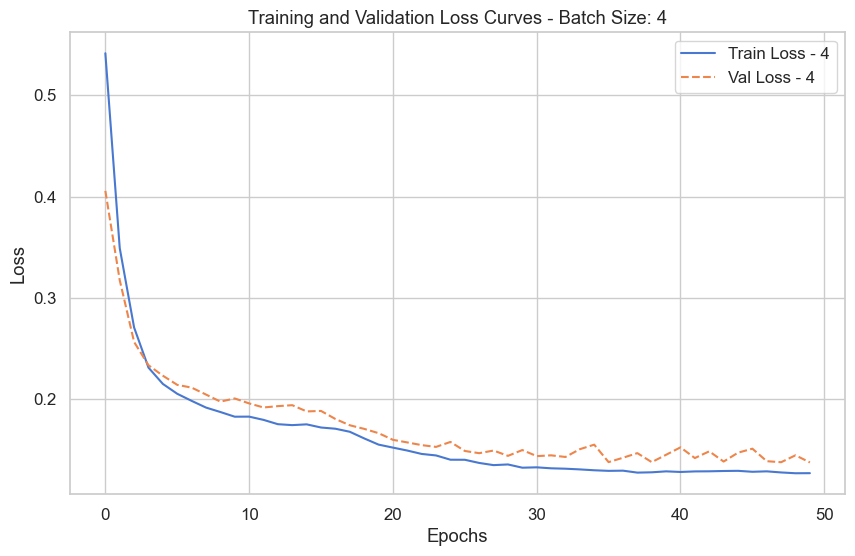

Saved plot: ../results/images/task5_plots/64_loss_curve.png


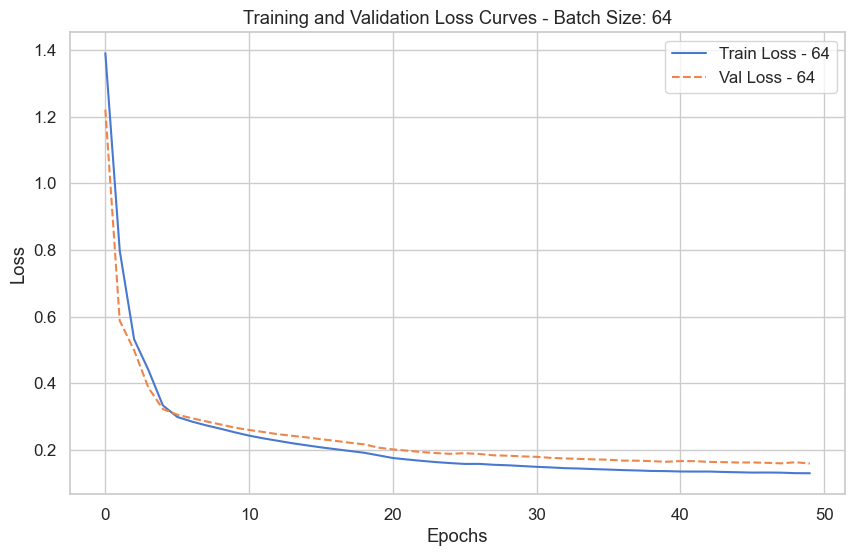

Saved plot: ../results/images/task5_plots/256_loss_curve.png


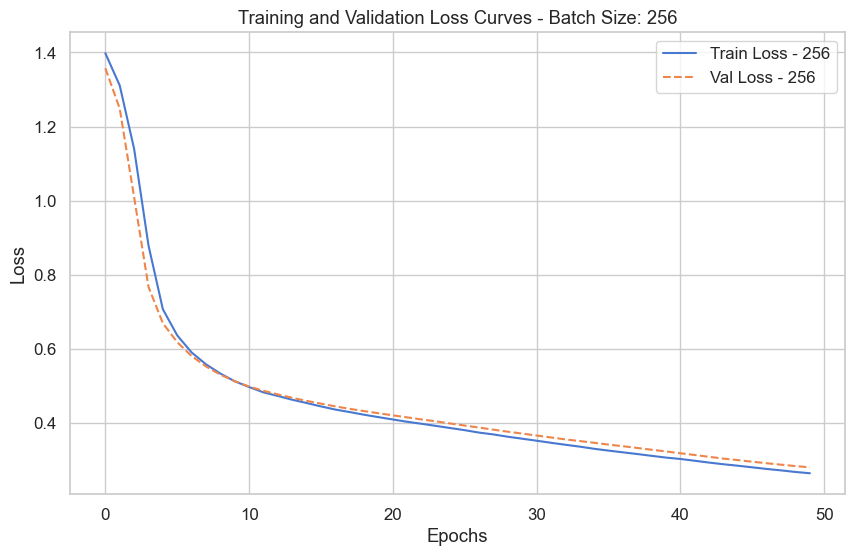

Saved plot: ../results/images/task5_plots/1024_loss_curve.png


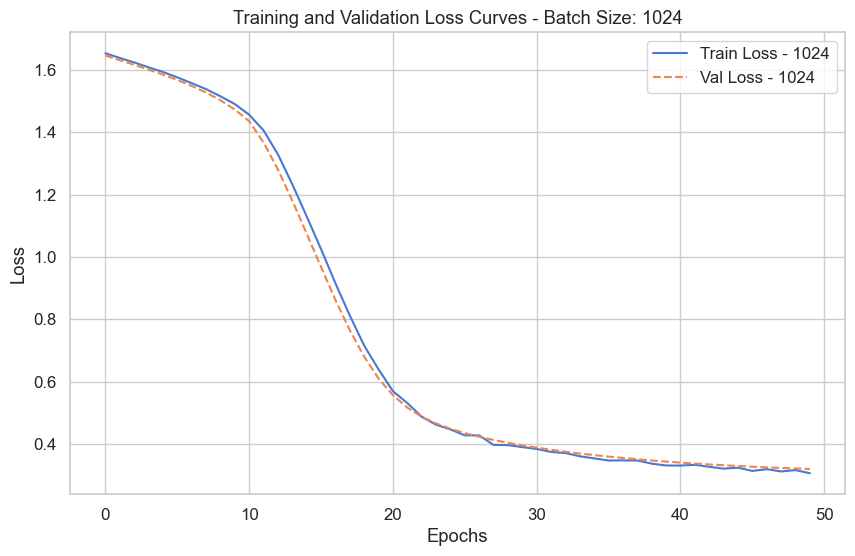

In [122]:
# --- Plot loss curves for all batch size experiments ---

for bs, (train_loss, val_loss) in batch_size_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {bs}')
    plt.plot(val_loss, '--', label=f'Val Loss - {bs}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - Batch Size: {bs}')
    plt.legend()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{bs}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

    plt.show()

#### Q: Use the best hyperparameter identified in the previous step and experiment with different batch sizes. In particular, use as batch size: {4, 64, 256, 1024}. Does performance change? And why? Report the validation results.

The batch size strongly affects model performance. Smaller batches (e.g., 4) yield the highest validation accuracy (94.9%) and macro F1 (0.69), while large batches (1024) lead to underfitting and accuracy drops to 89.7%. This occurs because small batches produce noisier gradient updates that enhance generalization, whereas large batches converge to smoother but less optimal minima. Therefore, the model performs best with small or moderate batch sizes (4-64), achieving both stability and high validation performance.

In conclusion, we selected the model with a batch size of 64, as it exhibited the smoothest and most stable loss curve.

In [123]:
# --- Print the times for each batch size training ---

print("\nTraining times for different batch sizes:")
for bs, results in batch_size_results.items():
    print(f"Batch Size {bs}: {results['training_time']:.4f} seconds")


Training times for different batch sizes:
Batch Size 4: 55.8748 seconds
Batch Size 64: 5.4656 seconds
Batch Size 256: 2.7542 seconds
Batch Size 1024: 3.2436 seconds


#### Q: How long does it take to train the models depending on the batch size? And why?

Training becomes faster with larger batch sizes because the model makes fewer updates per epoch and can process more data at once, using the hardware more efficiently.


That's why the jump from batch size 4 → 64 → 256 greatly reduces training time.


However, going from 256 to 1024 gives only a small speed gain — the hardware is already fully used, so the improvement levels off.





### The impact of the Optimizer

In [128]:
# --- Experiment with different optimizers ---

# Assuming 'best_deep_model_tag' and 'best_widths' are available
input_dim_deep = X_train_std_no_port.shape[1]
output_dim_deep = len(np.unique(y_train_no_port))
batch_size_opt = 64 # Use a reasonable batch size, e.g., 64

# Create DataLoaders for optimizer experiments
train_loader_opt = DataLoader(TensorDataset(X_train_tensor_no_port, y_train_tensor_no_port), batch_size=batch_size_opt, shuffle=True)
val_loader_opt   = DataLoader(TensorDataset(X_val_tensor_no_port, y_val_tensor_no_port), batch_size=batch_size_opt, shuffle=False)

optimizers_to_test = {
    'SGD': optim.SGD,
    'SGD_momentum_0.1': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.1),
    'SGD_momentum_0.5': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.5),
    'SGD_momentum_0.9': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
    'AdamW': optim.AdamW
}

optimizer_results = {}
optimizer_loss_curves = {}
trained_opt_models = {}

print(f"\nExperimenting with different optimizers for the best architecture ({best_deep_model_tag})...")

for opt_name, opt_class in optimizers_to_test.items():
    print(f"\nTraining with optimizer: {opt_name}")

    # Instantiate a fresh model for each optimizer experiment
    model_opt = DeepFFNN(input_dim_deep, best_widths, output_dim_deep, activation='relu')

    # Set hyperparameters (same as best ReLU model from Task 2/Task 5 baseline, but with optimizer variations)
    min_delta = 0.00001
    patience = 20
    criterion = nn.CrossEntropyLoss()
    lr = 0.0005 # Initial learning rate
    epochs = 50 # Use epochs from deep network training

    # Instantiate the optimizer
    if opt_name in ['SGD', 'AdamW']:
         optimizer = opt_class(model_opt.parameters(), lr=lr)
    else:
        optimizer = opt_class(model_opt.parameters(), lr=lr)

    # Move model to device
    model_opt = model_opt.to(device)

    start_time = time.time()
    # Training
    model_opt, train_loss_opt, val_loss_opt = train_model(
        model_opt,
        train_loader_opt,
        val_loader_opt,
        epochs,
        optimizer,
        criterion,
        min_delta,
        patience
    )
    end_time = time.time()
    training_time = end_time - start_time

    trained_opt_models[opt_name] = model_opt

    model_name = f"deep_L3_widths_{'_'.join(map(str, best_widths))}_opt_{opt_name}"

    # Evaluate on validation set
    report_opt = evaluate_model(model_opt, X_val_tensor_no_port, y_val_no_port, model_name)
    print(f"\nValidation report for optimizer {opt_name}:")
    print(report_opt)

    optimizer_results[opt_name] = {
        'training_time': training_time,
        'validation_report': report_opt
    }

    optimizer_loss_curves[opt_name] = (train_loss_opt, val_loss_opt)


Experimenting with different optimizers for the best architecture (deep_L3_widths_32_16_8)...

Training with optimizer: SGD
Epoch 1/50 - Train Loss: 1.5335, Val Loss: 1.5106
Epoch 5/50 - Train Loss: 1.3680, Val Loss: 1.3500
Epoch 10/50 - Train Loss: 1.2039, Val Loss: 1.1913
Epoch 15/50 - Train Loss: 1.0805, Val Loss: 1.0725
Epoch 20/50 - Train Loss: 0.9898, Val Loss: 0.9853
Epoch 25/50 - Train Loss: 0.9232, Val Loss: 0.9213
Epoch 30/50 - Train Loss: 0.8733, Val Loss: 0.8734
Epoch 35/50 - Train Loss: 0.8339, Val Loss: 0.8355
Epoch 40/50 - Train Loss: 0.8002, Val Loss: 0.8029
Epoch 45/50 - Train Loss: 0.7678, Val Loss: 0.7708
Epoch 50/50 - Train Loss: 0.7311, Val Loss: 0.7344

Validation report for optimizer SGD:
              precision    recall  f1-score   support

           0     0.7514    0.9985    0.8575      3378
           1     0.0000    0.0000    0.0000       285
           2     0.0000    0.0000    0.0000       774
           3     0.0000    0.0000    0.0000        57

    ac

Saved plot: ../results/images/task5_plots/SGD_loss_curve.png


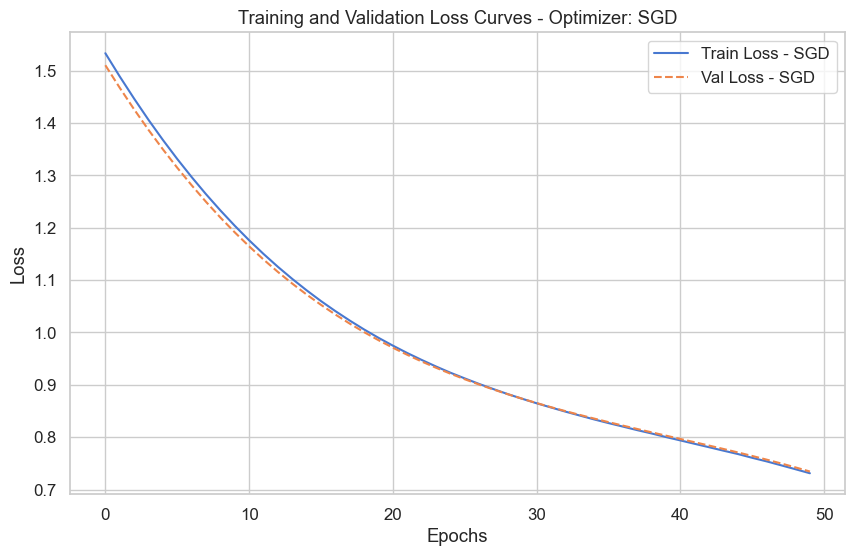

Saved plot: ../results/images/task5_plots/SGD_momentum_0.1_loss_curve.png


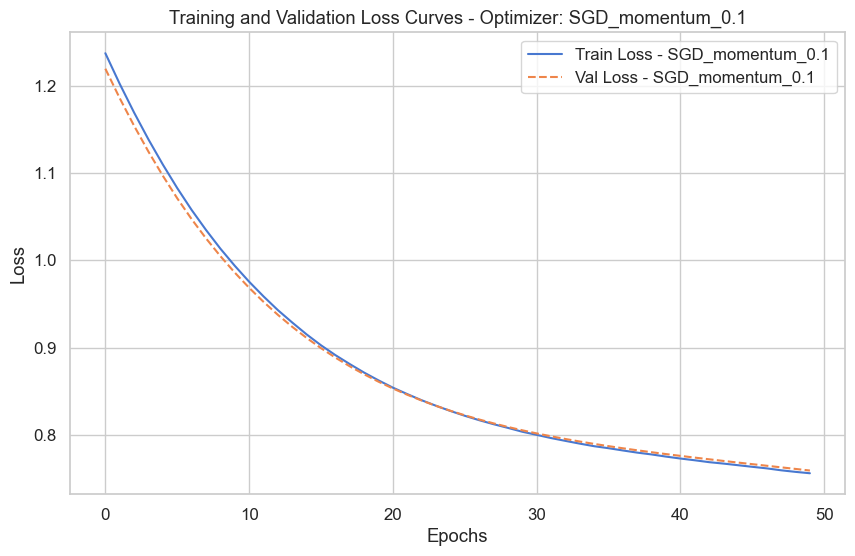

Saved plot: ../results/images/task5_plots/SGD_momentum_0.5_loss_curve.png


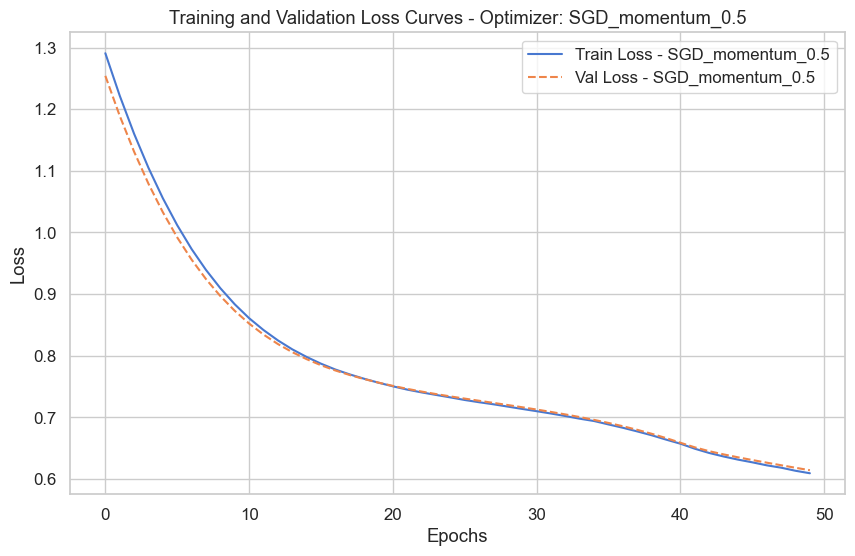

Saved plot: ../results/images/task5_plots/SGD_momentum_0.9_loss_curve.png


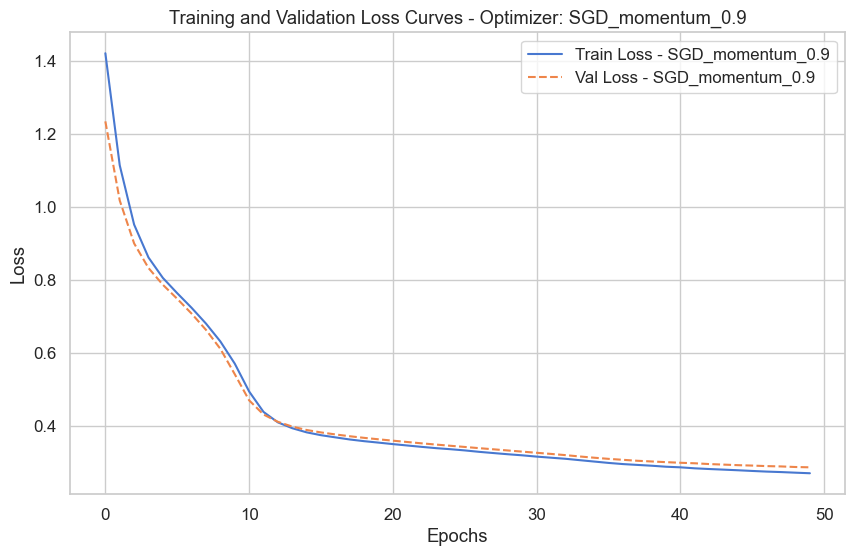

Saved plot: ../results/images/task5_plots/AdamW_loss_curve.png


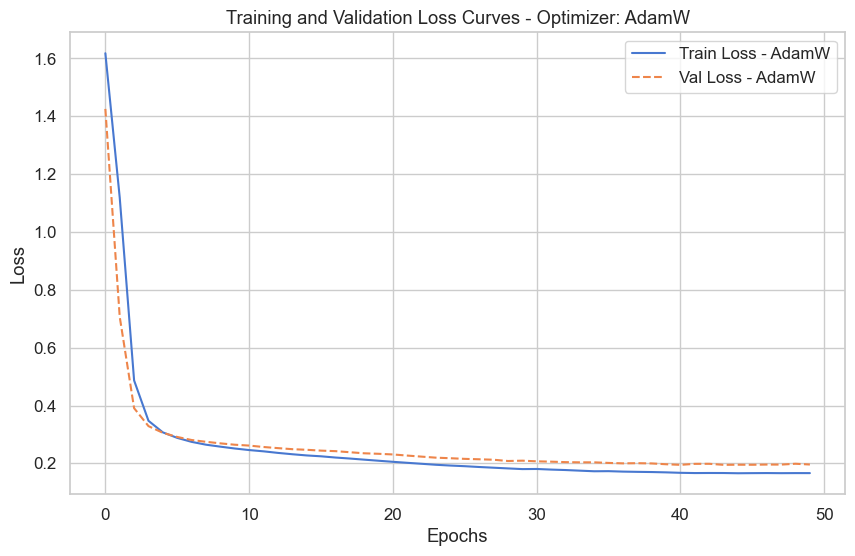

In [129]:
# --- Plot loss curves for all optimizer experiments ---

for opt_name, (train_loss, val_loss) in optimizer_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {opt_name}')
    plt.plot(val_loss, '--', label=f'Val Loss - {opt_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves - Optimizer: {opt_name}')
    plt.legend()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{opt_name}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

    plt.show()

#### Q: Finally, evaluate here how the optimizers affect the classification performance, training time and loss trend. The evaluated optimizers are: Stochastic Gradient Descent (SGD), SGD with Momentum(0.1, 0.5, 0.9) and AdamW. Is there a difference in the trend of the loss functions?

Yes, there is a clear difference in the loss trends:

- **AdamW** converges much faster and reaches a lower loss for both training and validation, showing efficient optimization and stable learning.

- **SGD without momentum** converges very slowly, with both losses staying high.

- **SGD with momentum** improves convergence as momentum increases (0.1 → 0.9), but still remains slower and less effective than AdamW.

In summary, **AdamW** shows the steepest and smoothest loss decrease, while SGD variants converge gradually, with higher final losses.

In [130]:
# --- Print the times for each batch size training ---

print("\nTraining times for different optimizers:")
for opt_name, results in optimizer_results.items():
    print(f"Optimizer {opt_name}: {results['training_time']:.4f} seconds")


Training times for different optimizers:
Optimizer SGD: 5.3055 seconds
Optimizer SGD_momentum_0.1: 4.5329 seconds
Optimizer SGD_momentum_0.5: 4.5588 seconds
Optimizer SGD_momentum_0.9: 4.5429 seconds
Optimizer AdamW: 5.5439 seconds


#### Q: How long does it take to train the models with the different optimizers? And why?

All runs use the same 50 epochs, so time mainly reflects per-update compute:

- **SGD with momentum** was fastest (≈4.5 s) because momentum smooths gradient updates, improving efficiency.
- **Plain SGD** (≈5.3 s) was slower due to noisier updates, and **AdamW** (≈5.5 s) took slightly longer because its adaptive learning-rate and weight-decay computations add overhead.

#### Q: Now, focus on the architecture with the best optimizer. Evaluate the effects of the different learning rates and epochs. Report the test results for the best model.

In [131]:
best_opt_model_tag = 'AdamW'
model = trained_opt_models[best_opt_model_tag]

print(f"\nTest set classification report ({best_opt_model_tag}):")
report = evaluate_model(model, X_test_tensor_no_port, y_test_no_port)
print(report)


Test set classification report (AdamW):
              precision    recall  f1-score   support

           0     0.9460    0.9701    0.9579      3378
           1     0.7625    0.9091    0.8293       286
           2     0.9835    0.8461    0.9096       773
           3     0.5000    0.2105    0.2963        57

    accuracy                         0.9352      4494
   macro avg     0.7980    0.7339    0.7483      4494
weighted avg     0.9351    0.9352    0.9330      4494



## **Task 6 — Overfitting and Regularization**

We analyze overfitting and apply regularization techniques to improve generalization.

Base model:
- Layers: **6**
- Hidden widths: [256, 128, 64, 32, 16]
- Activation: **ReLU**
- Optimizer: **AdamW**, learning rate = 5e-4
- Batch size: **128**
- Epochs: up to 50

Steps:
- Train baseline model and inspect loss curves for overfitting.
- Add **Dropout**, **Batch Normalization**, and **Weight Decay** (AdamW regularization).
- Compare validation/test performance across variants.
- Discuss which regularization technique best mitigates overfitting.

In [132]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task6_plots/'
os.makedirs(save_dir, exist_ok=True)

### Training

In [133]:
# --- Define 6-layer FFNN with Regularization Options ---

class RegularizedDeepFFNN(nn.Module):
    def __init__(self, input_dim, layer_widths, output_dim, activation='relu', dropout_prob=0.0, use_batchnorm=False):
        super(RegularizedDeepFFNN, self).__init__()
        layers = []
        prev_width = input_dim
        for i, width in enumerate(layer_widths):
            layers.append(nn.Linear(prev_width, width))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(width))
            if activation == 'relu':
                layers.append(nn.ReLU())
            if dropout_prob > 0 and i < len(layer_widths) - 1: # Apply dropout to hidden layers
                layers.append(nn.Dropout(dropout_prob))
            prev_width = width
        layers.append(nn.Linear(prev_width, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [134]:
# --- Experiment with Regularization ---

input_dim_reg = X_train_std_no_port.shape[1]
output_dim_reg = len(np.unique(y_train_no_port))
layer_widths_reg = [256, 128, 64, 32, 16] # Same widths as the baseline 6-layer model

# Define hyperparameters for regularization experiments
base_lr = 0.0005
epochs_reg = 50
batch_size_reg = 128
min_delta_reg = 0.00001
patience_reg = 20

regularization_configs = {
    'Baseline': # No dropout, no batch norm, no weight decay
        {'dropout_prob': 0.0, 'use_batchnorm': False, 'weight_decay': 0.0},
    'Dropout_0.5': # Dropout 50% (no BN, no weight decay)
        {'dropout_prob': 0.5, 'use_batchnorm': False, 'weight_decay': 0.0},
    'BatchNorm': # Batch normalization only
        {'use_batchnorm': True, 'dropout_prob': 0.0, 'weight_decay': 0.0},
    'BatchNorm_Dropout_0.5': # BatchNorm + Dropout 50%
        {'use_batchnorm': True, 'dropout_prob': 0.5, 'weight_decay': 0.0},
    'WeightDecay_1e-4': # L2 regularization via weight_decay=1e-4 (no dropout, no BN)
        {'dropout_prob': 0.0, 'use_batchnorm': False, 'weight_decay': 1e-4},
    'WeightDecay_1e-4_BN_Dropout_0.5': # All three: BatchNorm + Dropout 50% + Weight Decay 1e-4
        {'use_batchnorm': True, 'dropout_prob': 0.5, 'weight_decay': 1e-4}
}

regularized_models = {}
regularized_loss_curves = {}
regularized_validation_reports = {}
regularized_test_reports = {}

for config_name, params in regularization_configs.items():
    print(f"\nTraining model with {config_name}...")

    # Instantiate model with regularization
    model_reg = RegularizedDeepFFNN(
        input_dim_reg,
        layer_widths_reg,
        output_dim_reg,
        activation='relu',
        dropout_prob=params.get('dropout_prob', 0.0),
        use_batchnorm=params.get('use_batchnorm', False)
    )

    # Define optimizer with weight decay
    optimizer_reg = optim.AdamW(model_reg.parameters(), lr=base_lr, weight_decay=params.get('weight_decay', 0.0))
    criterion = nn.CrossEntropyLoss()

    # Create DataLoaders (using the same as the baseline 6-layer model)
    train_loader_reg = train_loader_no_port
    val_loader_reg = val_loader_no_port

    # Move model to device
    model_reg = model_reg.to(device)

    # Training
    model_reg, train_loss_reg, val_loss_reg = train_model(
        model_reg,
        train_loader_reg,
        val_loader_reg,
        epochs_reg,
        optimizer_reg,
        criterion,
        min_delta=min_delta_reg,
        patience=patience_reg
    )

    regularized_models[config_name] = model_reg
    regularized_loss_curves[config_name] = (train_loss_reg, val_loss_reg)

    model_name = f"deep_L3_widths_{'_'.join(map(str, layer_widths_reg))}_reg_{config_name}"

    # Evaluate on validation set
    report_val_reg = evaluate_model(model_reg, X_val_tensor_no_port, y_val_no_port, model_name)
    regularized_validation_reports[config_name] = report_val_reg
    print(f"\nValidation report for {config_name}:")
    print(report_val_reg)

    # Evaluate on test set
    report_test_reg = evaluate_model(model_reg, X_test_tensor_no_port, y_test_no_port)
    regularized_test_reports[config_name] = report_test_reg
    print(f"\nTest report for {config_name}:")
    print(report_test_reg)

# It is now possible compare the reports in regularized_validation_reports and regularized_test_reports


Training model with Baseline...
Epoch 1/50 - Train Loss: 0.5173, Val Loss: 0.3061
Epoch 5/50 - Train Loss: 0.1596, Val Loss: 0.1743
Epoch 10/50 - Train Loss: 0.1285, Val Loss: 0.1380
Epoch 15/50 - Train Loss: 0.1228, Val Loss: 0.1478
Epoch 20/50 - Train Loss: 0.1155, Val Loss: 0.1316
Epoch 25/50 - Train Loss: 0.1120, Val Loss: 0.1249
Epoch 30/50 - Train Loss: 0.1099, Val Loss: 0.1217
Epoch 35/50 - Train Loss: 0.1036, Val Loss: 0.1207
Epoch 40/50 - Train Loss: 0.1050, Val Loss: 0.1286
Epoch 45/50 - Train Loss: 0.1015, Val Loss: 0.1306
Epoch 50/50 - Train Loss: 0.1016, Val Loss: 0.1225

Validation report for Baseline:
              precision    recall  f1-score   support

           0     0.9585    0.9908    0.9744      3378
           1     0.9308    0.9439    0.9373       285
           2     0.9872    0.8953    0.9390       774
           3     0.3636    0.0702    0.1176        57

    accuracy                         0.9597      4494
   macro avg     0.8100    0.7251    0.7421      

### Evaluating

Saved plot: ../results/images/task6_plots/Baseline_loss_curve.png


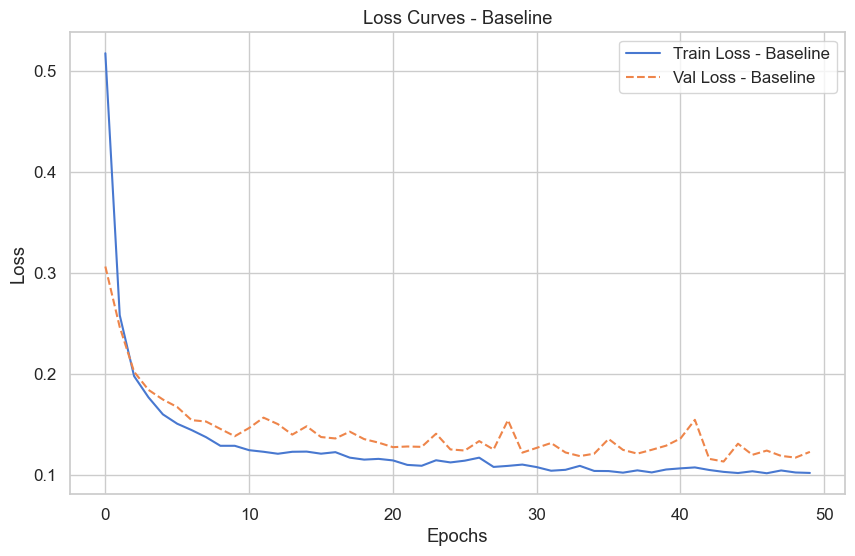

Saved plot: ../results/images/task6_plots/Dropout_0.5_loss_curve.png


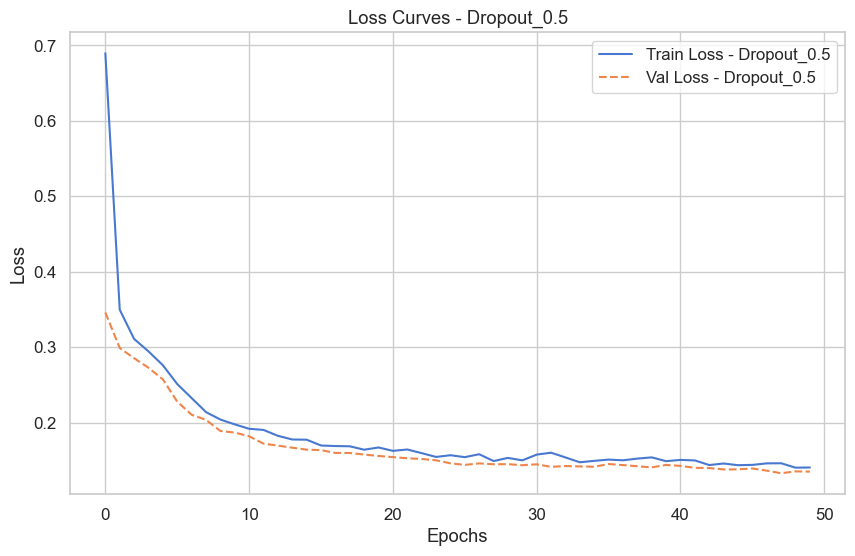

Saved plot: ../results/images/task6_plots/BatchNorm_loss_curve.png


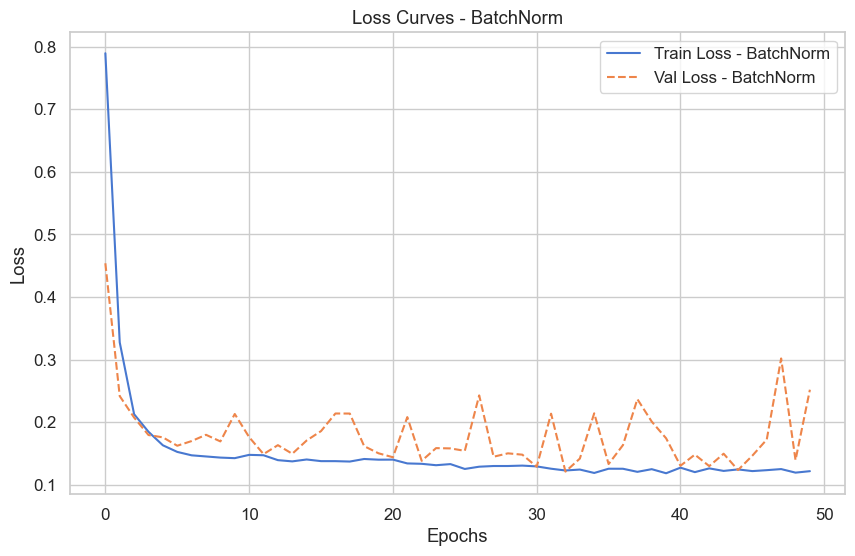

Saved plot: ../results/images/task6_plots/BatchNorm_Dropout_0.5_loss_curve.png


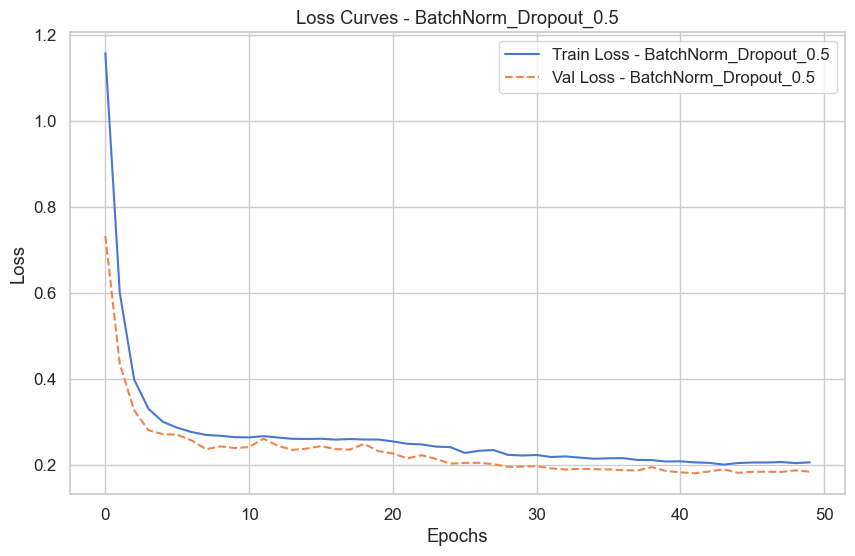

Saved plot: ../results/images/task6_plots/WeightDecay_1e-4_loss_curve.png


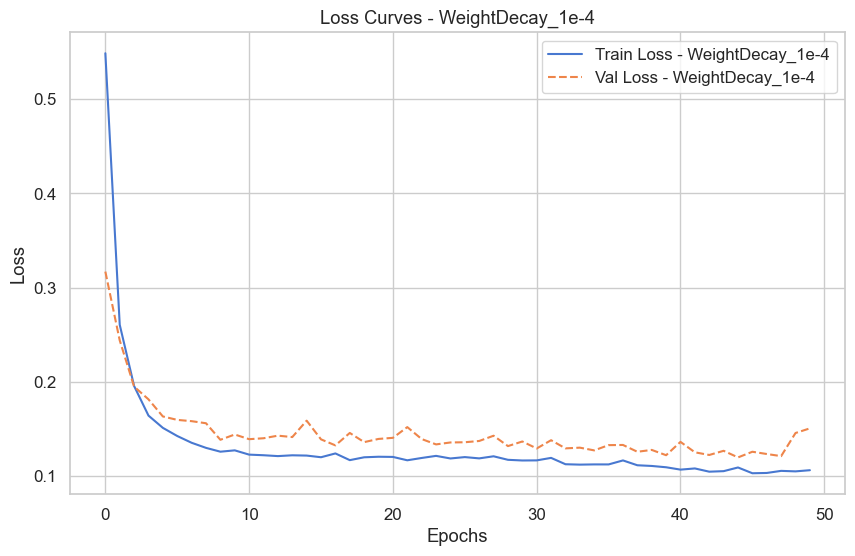

Saved plot: ../results/images/task6_plots/WeightDecay_1e-4_BN_Dropout_0.5_loss_curve.png


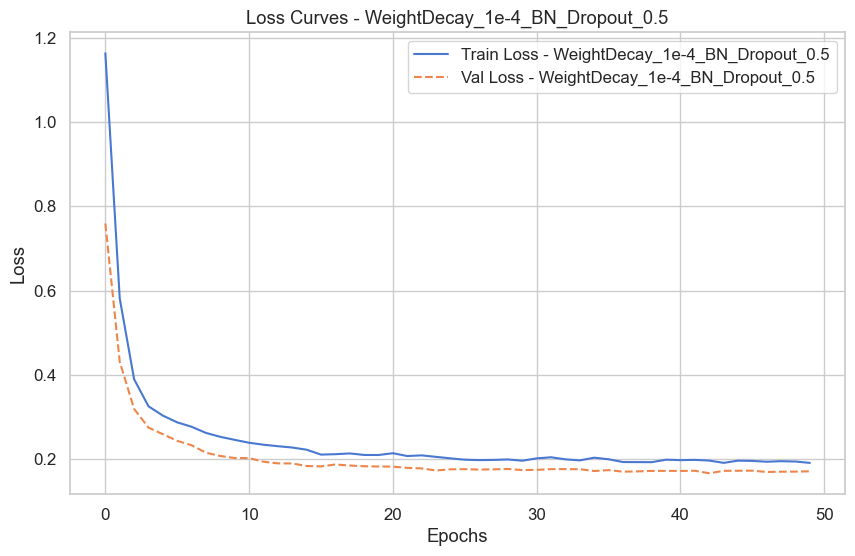

In [135]:
# --- Plot loss curves for all regularized models ---

for config_name, (train_loss, val_loss) in regularized_loss_curves.items():
    plt.figure(figsize=(10,6))
    plt.plot(train_loss, label=f'Train Loss - {config_name}')
    plt.plot(val_loss, '--', label=f'Val Loss - {config_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves - {config_name}')
    plt.legend()

    # Save the plot to the specified path
    save_plot(plt.gcf(), f"{config_name}_loss_curve", save_dir) # Use plt.gcf() to get the current figure

    plt.show()

#### Q: Each Neurons per Layer describes how many neurons must be present in each layer. For example: 1st layer 256, 2nd layer 128 etc. What do the losses look like? Is the model overfitting?

The training and validation losses both decrease smoothly and stabilize around 0.10-0.12, showing consistent convergence.
The validation loss stays slightly higher than the training loss, which is expected — this indicates good generalization rather than overfitting.

If the model were overfitting, we would see the training loss continue to drop while the validation loss increased or fluctuated strongly. Here, both curves follow the same trend and plateau together.

The losses show a healthy training process — the model converges well and does not overfit, maintaining high validation accuracy (~96%).


#### Q: Now apply normalization techniques (dropout, batch normalization) and play with the regularization of the weights (AdamW's weight decay). What impact do the different normalization techniques have on validation and testing performance?

Impact summary:

- **Baseline (AdamW)** - Best overall (Val 96%, Test 96%). Smooth convergence, no overfitting, and correct predictions for all classes.

- **Dropout (0.5)** - Validation loss a bit lower than training; minority class (3) never predicted.

- **BatchNorm** - Validation loss unstable, signs of overfitting/instability; poor minority class recall.

- **BatchNorm + Dropout (0.5)** - Too much regularization → strong underfitting; class 3 ignored.

- **Weight Decay (1e-4)** - Slightly improves generalization and keeps losses stable; close to baseline.

- **Weight Decay + BN + Dropout (0.5)** - Over-regularized; underfits, poor validation.

Best setup: *AdamW + small weight decay (1e-4)*.

Too strong: *Dropout / BatchNorm* on this tabular dataset → underfitting, unstable validation.

---